## <center>**Livrable pour le projet Intelligence Artificielle**</center>

‎ 
‎ 

*Document réalisé par le **groupe 3**, composé de :*
- *GAURE Warren*
- *JOURNEL Nicolas*
- *LAVAUX Esteban*
- *ROCHARD Léo*

‎ 

---

### **Sommaire**

1. [Importation des bibliothèques](#importation)
2. [Chargement et aperçu des données initiales](#chargement)
3. [Résumés des datasets initiaux](#resumes)
4. [Prétraitement des données](#preprocessing)
5. [Suppression des colonnes non pertinentes](#suppression-colonnes)
6. [Aperçu du dataset global](#apercu-global)
7. [Détection des valeurs manquantes](#missing-check)
8. [Pipeline de traitement des données](#pipeline)
9. [EDA](#eda)
10. [Entraînement, évaluation et optimisation des modèles](#model-training-evaluation-optimization)
11. [Analyse des résultats et conclusions](#analyse-resultats)

‎ 

---

### 1. <a id='importation'>Importation des bibliothèques</a>

In [130]:
import time
import warnings
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Ignorer les avertissements
warnings.filterwarnings('ignore')

PATH = "../data/"
DELIMITER = "--------------------------------"

---

### 2. <a id='chargement'>Chargement et aperçu des données initiales</a>

In [131]:
employee_df = pd.read_csv(PATH + "employee_survey_data.csv")
general_df = pd.read_csv(PATH + "general_data.csv")
manager_df = pd.read_csv(PATH + "manager_survey_data.csv")
in_time_df = pd.read_csv(PATH + "in_time.csv")
out_time_df = pd.read_csv(PATH + "out_time.csv")

dataframes = [
    ("employee_df", employee_df),
    ("general_df", general_df),
    ("manager_df", manager_df),
    ("in_time_df", in_time_df),
    ("out_time_df", out_time_df)
]

small_delimiter = "-" * 10

for name, df in dataframes:
    print(DELIMITER)

    print(f"Nom du dataset : {name}")
    print(small_delimiter)

    print(f"Nombre de lignes du dataset : {df.shape[0]}")
    print(f"Nombre de colonnes du dataset : {df.shape[1]}")
    print(small_delimiter)

    print("Informations de base :")
    print(df.info())
    print(small_delimiter)

    print(f"Statistiques :\n{df.describe()}")
    print(small_delimiter)

    print(f"Valeurs nulles :\n{df.isnull().sum()}")
    print(small_delimiter)

    print("Premières lignes du dataset :")
    print(df.head())

--------------------------------
Nom du dataset : employee_df
----------
Nombre de lignes du dataset : 4410
Nombre de colonnes du dataset : 4
----------
Informations de base :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB
None
----------
Statistiques :
       EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count   4410.0000                4385.0000        4390.0000        4372.0000
mean    2205.5000                   2.7236           2.7282           2.7614
std     1273.2017                   1.0928           1.1013           0.7062
min

---

### 3. <a id='resumes'>Résumés des datasets initiaux</a>

#### 3.1. Dataset `employee_df`
| #  | Colonne                   | Type      | Description                                    | Valeurs manquantes | Moyenne | Médiane | Min | Max |
|----|---------------------------|-----------|-----------------------------------------------|--------------------|---------|---------|-----|-----|
| 1  | EmployeeID                | int64     | Identifiant unique pour chaque employé       | 0                  | -       | -       | -   | -   |
| 2  | EnvironmentSatisfaction   | float64   | Satisfaction par rapport à l’environnement   | 25                 | 2.72    | 3       | 1   | 4   |
| 3  | JobSatisfaction           | float64   | Satisfaction au travail                      | 20                 | 2.73    | 3       | 1   | 4   |
| 4  | WorkLifeBalance           | float64   | Équilibre vie pro/perso                      | 38                 | 2.76    | 3       | 1   | 4   |

‎

──────────────────────────────────────────────────

#### 3.2. Dataset `general_df`
| #  | Colonne                     | Type      | Description                                    | Valeurs manquantes | Moyenne   | Médiane | Min | Max      |
|----|-----------------------------|-----------|-----------------------------------------------|--------------------|-----------|---------|-----|----------|
| 1  | Age                         | int64     | Âge des employés                              | 0                  | 36.92     | 36      | 18  | 60       |
| 2  | Attrition                   | object    | Indique si l'employé a quitté l'entreprise    | 0                  | -         | -       | -   | -        |
| 3  | BusinessTravel              | object    | Fréquence des déplacements professionnels     | 0                  | -         | -       | -   | -        |
| 4  | Department                  | object    | Département auquel l'employé appartient       | 0                  | -         | -       | -   | -        |
| 5  | DistanceFromHome            | int64     | Distance entre domicile et lieu de travail    | 0                  | 9.19      | 7       | 1   | 29       |
| 6  | Education                   | int64     | Niveau d'éducation (1 à 5)                    | 0                  | 2.91      | 3       | 1   | 5        |
| 7  | EducationField              | object    | Domaine d'étude                               | 0                  | -         | -       | -   | -        |
| 8  | EmployeeCount               | int64     | Toujours égal à 1                             | 0                  | 1.0       | 1       | 1   | 1        |
| 9  | EmployeeID                  | int64     | Identifiant unique pour chaque employé        | 0                  | -         | -       | 1   | 4410     |
| 10 | Gender                      | object    | Genre de l'employé                            | 0                  | -         | -       | -   | -        |
| 11 | JobLevel                    | int64     | Niveau de poste (1 à 5)                       | 0                  | 2.06      | 2       | 1   | 5        |
| 12 | JobRole                     | object    | Intitulé du poste                             | 0                  | -         | -       | -   | -        |
| 13 | MaritalStatus               | object    | État civil                                    | 0                  | -         | -       | -   | -        |
| 14 | MonthlyIncome               | int64     | Revenu mensuel (en dollars)                  | 0                  | 65,029    | 49,190  | 10,090 | 199,990 |
| 15 | NumCompaniesWorked          | float64   | Nombre d'entreprises où l'employé a travaillé| 19                 | 2.69      | 2       | 0   | 9        |
| 16 | Over18                      | object    | Toujours "Y"                                | 0                  | -         | -       | -   | -        |
| 17 | PercentSalaryHike           | int64     | Augmentation de salaire en %                  | 0                  | 15.21     | 14      | 11  | 25       |
| 18 | StandardHours               | int64     | Toujours égal à 8                             | 0                  | 8.0       | 8       | 8   | 8        |
| 19 | StockOptionLevel            | int64     | Niveau d'options sur actions (0 à 3)         | 0                  | 0.79      | 1       | 0   | 3        |
| 20 | TotalWorkingYears           | float64   | Années totales d'expérience                  | 9                  | 11.28     | 10      | 0   | 40       |
| 21 | TrainingTimesLastYear       | int64     | Nombre de formations l'année précédente       | 0                  | 2.80      | 3       | 0   | 6        |
| 22 | YearsAtCompany              | int64     | Années passées dans l'entreprise              | 0                  | 7.01      | 5       | 0   | 40       |
| 23 | YearsSinceLastPromotion     | int64     | Années depuis la dernière promotion           | 0                  | 2.19      | 1       | 0   | 15       |
| 24 | YearsWithCurrManager        | int64     | Années passées avec le manager actuel         | 0                  | 4.12      | 3       | 0   | 17       |

‎

──────────────────────────────────────────────────

#### 3.3. Dataset `manager_df`
| #  | Colonne              | Type    | Description                               | Valeurs manquantes | Moyenne | Médiane | Min | Max | 
|----|----------------------|---------|-------------------------------------------|--------------------|---------|---------|-----|-----|
| 1  | EmployeeID          | int64   | Identifiant unique pour chaque employé   | 0                  | -       | -       | -   | -   |
| 2  | JobInvolvement      | int64   | Implication dans le travail (1 à 4)      | 0                  | 2.73    | 3       | 1   | 4   |
| 3  | PerformanceRating   | int64   | Évaluation de la performance (3 à 4)     | 0                  | 3.15    | 3       | 3   | 4   |

‎

──────────────────────────────────────────────────

#### 3.4. Dataset `in_time_df`
| #  | Colonne              | Type    | Description                               | Valeurs manquantes |
|----|----------------------|---------|-------------------------------------------|--------------------|
| 1  | Unnamed: 0          | int64   | Identifiant unique pour chaque employé   | 0                  |
| 2  | 2015-01-01      | float64   | Date d'arrivée      | 4410                  |
| 3  | 2015-01-02   | object   | Date d'arrivée     | 209                  |
| ...  | 2015-31-12   | object   | Date de départ     | 213                  |

‎

──────────────────────────────────────────────────

#### 3.5. Dataset `out_time_df`
| #  | Colonne              | Type    | Description                               | Valeurs manquantes |
|----|----------------------|---------|-------------------------------------------|--------------------|
| 1  | Unnamed: 0          | int64   | Identifiant unique pour chaque employé   | 0                  |
| 2  | 2015-01-01      | float64   | Date de départ      | 4410                  |
| 3  | 2015-01-02   | object   | Date de départ     | 209                  |
| ...  | 2015-31-12   | object   | Date de départ     | 213                  |

‎

---


### 4. <a id='preprocessing'>Prétraitement des données</a>

Notre objectif est de venir merger ces différents datasets afin de travailler avec un seul DataFrame.
En observant les différentes caractéristiques des dataset, nous nous sommes aperçus que nous pouvons dès à présent fusionner tous les datasets, à l'exception de `in_time_df` et `out_time_df` de part la nature des informations présentes qui diffère grandement des autres dataset, que cela soit sur la forme ou bien sur le fond.

Nous allons donc venir synthétiser ces données afin de récupérer l'heure totale de travail pour chaque employé.

#### 4.1. Fusion des datasets `in_time_df` et `out_time_df`

In [132]:
in_time_df = in_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})
out_time_df = out_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})

# Vérifications concernant les 2 datasets :

# Valeurs des EmployeeID
if not in_time_df['EmployeeID'].equals(out_time_df['EmployeeID']):
    print("Les EmployeeID ne correspondent pas entre les dataset : in_time_df et out_time_df")

# Correspondance des valeurs N/A
in_time_na = in_time_df.isna()
out_time_na = out_time_df.isna()
if not in_time_na.equals(out_time_na):
    print("Les valeurs NA dans in_time_df et out_time_df ne correspondent pas")

# On est maintenant sûr que les datasets sont conformes et peuvent donc être fusionnés
# On va venir convertir les objets en date afin de récuperer les heures totales.

for col in in_time_df.columns[1:]:
    in_time_df[col] = pd.to_datetime(in_time_df[col], errors='coerce')
    out_time_df[col] = pd.to_datetime(out_time_df[col], errors='coerce')

time_difference = out_time_df.iloc[:, 1:] - in_time_df.iloc[:, 1:]

time_difference_in_hours = time_difference.apply(lambda row: row.dt.total_seconds() / 3600, axis=1)
total_hours_per_employee = time_difference_in_hours.sum(axis=1, skipna=True).round(2)

out_time_df["Total_Hours"] = total_hours_per_employee
total_hours_df = out_time_df[["EmployeeID", "Total_Hours"]]
display(total_hours_df)

,EmployeeID,Total_Hours
0,1,1710.6900
1,2,1821.6800
2,3,1697.2000
3,4,1690.5100
4,5,1961.5100
...,...,...
4405,4406,2070.9100
4406,4407,1468.4000
4407,4408,1780.2300
4408,4409,2287.7200


──────────────────────────────────────────────────

#### 4.2. Fusion de tous les datasets

In [133]:
company_df = general_df.merge(employee_df, on='EmployeeID').merge(manager_df, on='EmployeeID').merge(total_hours_df, on='EmployeeID')
display(company_df)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0000,4.0000,2.0000,3,3,1710.6900
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0000,2.0000,4.0000,2,4,1821.6800
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0000,2.0000,1.0000,3,3,1697.2000
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0000,4.0000,3.0000,2,3,1690.5100
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0000,1.0000,3.0000,3,3,1961.5100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,5,3,0,2,4.0000,1.0000,3.0000,3,3,2070.9100
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,2,3,0,2,4.0000,4.0000,3.0000,2,3,1468.4000
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,4,1,2,1.0000,3.0000,3.0000,3,4,1780.2300
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,2,9,7,8,4.0000,1.0000,3.0000,2,3,2287.7200


---

### 5. <a id='suppression-colonnes'>Suppression des colonnes non pertinentes</a>

Après étude des différentes colonnes, nous pouvons voir que les colonnes `EmployeeCount` et `Over18` et `StandardHours` ne contiennent qu'une seule valeur. Nous pouvons donc les supprimer.

Le `Gender` ainsi que `MaritalStatus` sont des données pouvant susciter de la discrimination éthiquement parlant, nous avons donc fait le choix de les supprimer ausis.

L'`EmployeeID` est une colonne contenant une valeur unique pour chaque employé, valeur servant à des fins d'identification dans les systèmes de l'entreprise *HumanForYou*, nous pouvons donc la supprimer également.

In [134]:
company_df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID', 'Gender', 'MaritalStatus'], axis=1, inplace=True)

De plus, toujours dans notre démarche éthique, nous avons également décidé de modifier la colonne `Age` pour qu'elle représente des tranches d'âge, afin d'anonymiser cette donnée.

In [135]:
def categorize_age(df):
    bins = [0, 20, 30, 36, 44, float('inf')]
    labels = ['<=20', '21-30', '31-36', '37-43', '>44']
    df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
    return df


company_df = categorize_age(company_df)

---

### 6. <a id='apercu-global'>Aperçu du dataset global</a>

In [136]:
print(f"Nombre de lignes : {company_df.shape[0]}")
print(f"Nombre de colonnes : {company_df.shape[1]}")

Nombre de lignes : 4410
Nombre de colonnes : 24


In [137]:
print("Informations de base :")
company_df.info()

Informations de base :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      4410 non-null   category
 1   Attrition                4410 non-null   object  
 2   BusinessTravel           4410 non-null   object  
 3   Department               4410 non-null   object  
 4   DistanceFromHome         4410 non-null   int64   
 5   Education                4410 non-null   int64   
 6   EducationField           4410 non-null   object  
 7   JobLevel                 4410 non-null   int64   
 8   JobRole                  4410 non-null   object  
 9   MonthlyIncome            4410 non-null   int64   
 10  NumCompaniesWorked       4391 non-null   float64 
 11  PercentSalaryHike        4410 non-null   int64   
 12  StockOptionLevel         4410 non-null   int64   
 13  TotalWorkingYears        4401 non-null  

In [138]:
print(f"Sommaire des statistiques : \n{company_df.describe()}")

Sommaire des statistiques : 
       DistanceFromHome  Education  JobLevel  MonthlyIncome  \
count         4410.0000  4410.0000 4410.0000      4410.0000   
mean             9.1925     2.9129    2.0639     65029.3129   
std              8.1050     1.0239    1.1067     47068.8886   
min              1.0000     1.0000    1.0000     10090.0000   
25%              2.0000     2.0000    1.0000     29110.0000   
50%              7.0000     3.0000    2.0000     49190.0000   
75%             14.0000     4.0000    3.0000     83800.0000   
max             29.0000     5.0000    5.0000    199990.0000   

       NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  \
count           4391.0000          4410.0000         4410.0000   
mean               2.6948            15.2095            0.7939   
std                2.4989             3.6591            0.8519   
min                0.0000            11.0000            0.0000   
25%                1.0000            12.0000            0.0000   
50%    

In [139]:
print("Nombre de valeurs uniques par colonne :")
for column in company_df.columns:
    print(f"- {column} : {company_df[column].nunique()} valeurs uniques")

Nombre de valeurs uniques par colonne :
- Age : 5 valeurs uniques
- Attrition : 2 valeurs uniques
- BusinessTravel : 3 valeurs uniques
- Department : 3 valeurs uniques
- DistanceFromHome : 29 valeurs uniques
- Education : 5 valeurs uniques
- EducationField : 6 valeurs uniques
- JobLevel : 5 valeurs uniques
- JobRole : 9 valeurs uniques
- MonthlyIncome : 1349 valeurs uniques
- NumCompaniesWorked : 10 valeurs uniques
- PercentSalaryHike : 15 valeurs uniques
- StockOptionLevel : 4 valeurs uniques
- TotalWorkingYears : 40 valeurs uniques
- TrainingTimesLastYear : 7 valeurs uniques
- YearsAtCompany : 37 valeurs uniques
- YearsSinceLastPromotion : 16 valeurs uniques
- YearsWithCurrManager : 18 valeurs uniques
- EnvironmentSatisfaction : 4 valeurs uniques
- JobSatisfaction : 4 valeurs uniques
- WorkLifeBalance : 4 valeurs uniques
- JobInvolvement : 4 valeurs uniques
- PerformanceRating : 2 valeurs uniques
- Total_Hours : 4300 valeurs uniques


In [140]:
display(company_df.head())

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,>44,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,...,6,1,0,0,3.0000,4.0000,2.0000,3,3,1710.6900
1,31-36,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,...,3,5,1,4,3.0000,2.0000,4.0000,2,4,1821.6800
2,31-36,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,...,2,5,0,3,2.0000,2.0000,1.0000,3,3,1697.2000
3,37-43,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,...,5,8,7,5,4.0000,4.0000,3.0000,2,3,1690.5100
4,31-36,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,...,2,6,0,4,4.0000,1.0000,3.0000,3,3,1961.5100


---

### 7. <a id='missing-check'>Détection des valeurs manquantes</a>

Valeurs manquantes par colonne :
NumCompaniesWorked : 19 valeurs (0.43%)
TotalWorkingYears : 9 valeurs (0.2%)
EnvironmentSatisfaction : 25 valeurs (0.57%)
JobSatisfaction : 20 valeurs (0.45%)
WorkLifeBalance : 38 valeurs (0.86%)


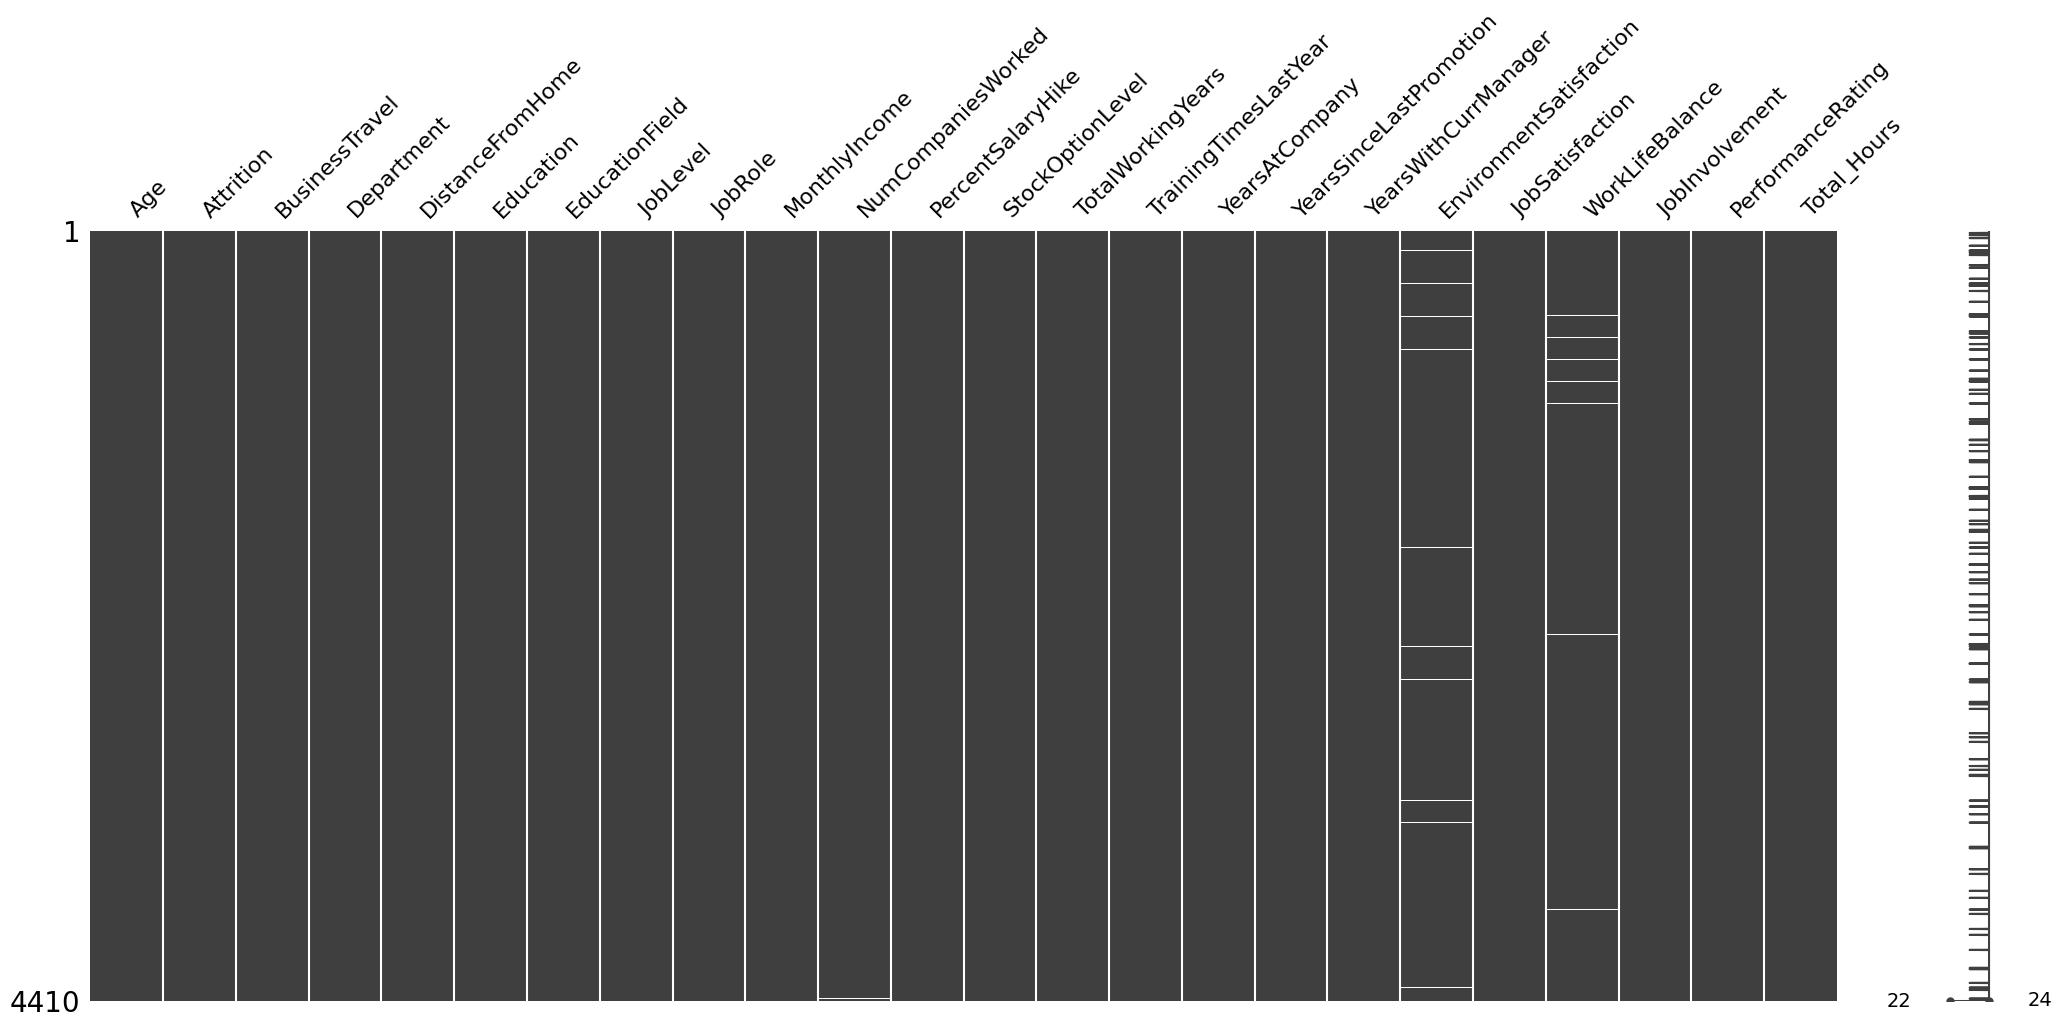

In [141]:
def check_missing_values(df):
    if (df.isnull().sum() > 0).any():
        missing_values = df.isnull().sum()[df.isnull().sum() > 0]
        missing_percentage = (missing_values / len(df) * 100).round(2)
        print("Valeurs manquantes par colonne :")
        for col in missing_values.index:
            print(f"{col} : {missing_values[col]} valeurs ({missing_percentage[col]}%)")
    else:
        print("Il n'y a pas de valeurs manquantes dans le dataset")
    msno.matrix(df)
    plt.show()

check_missing_values(company_df)

Nous pouvons remarquer qu'il existe des données manquantes dans certaines colonnes de notre dataset. Étant donné que le nombre de valeurs manquantes est très faible (> 1% des données pour chaque colonne concernée), nous pouvons nous permettre de visualiser les distributions des variables avant de décider de quelle manière les gérer.


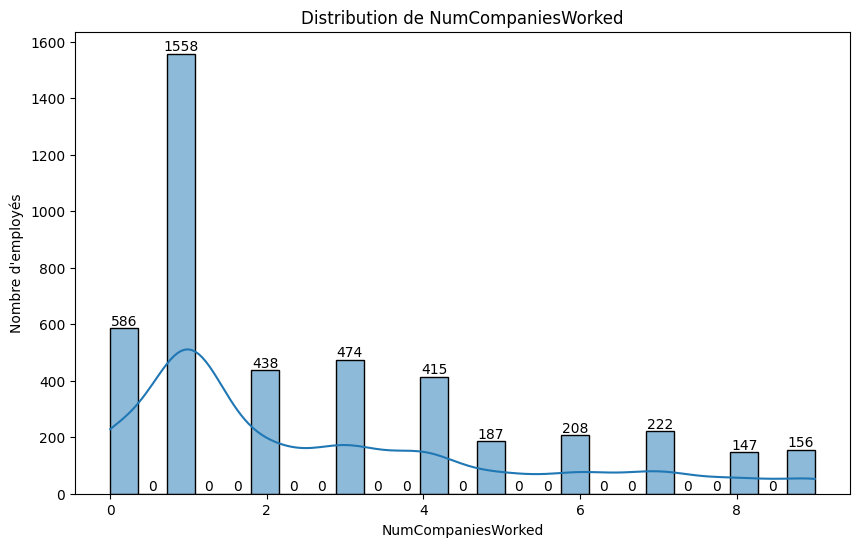

--------------------------------


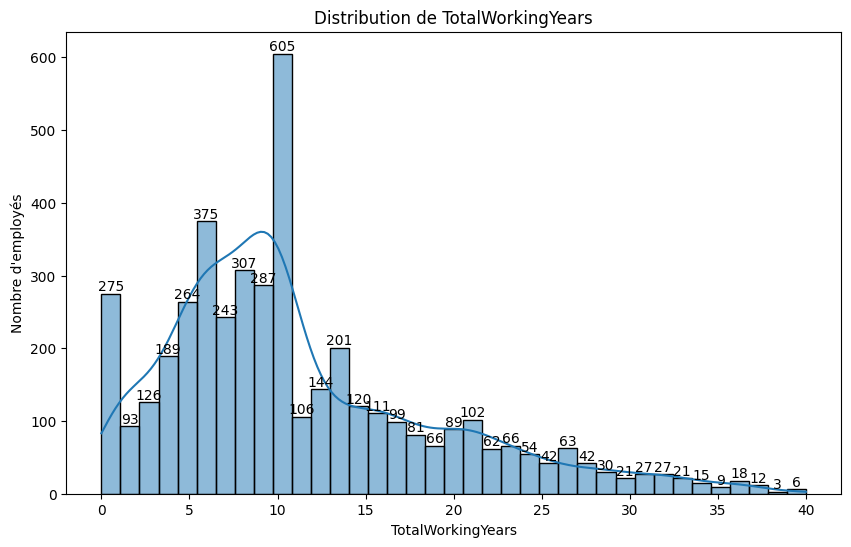

--------------------------------


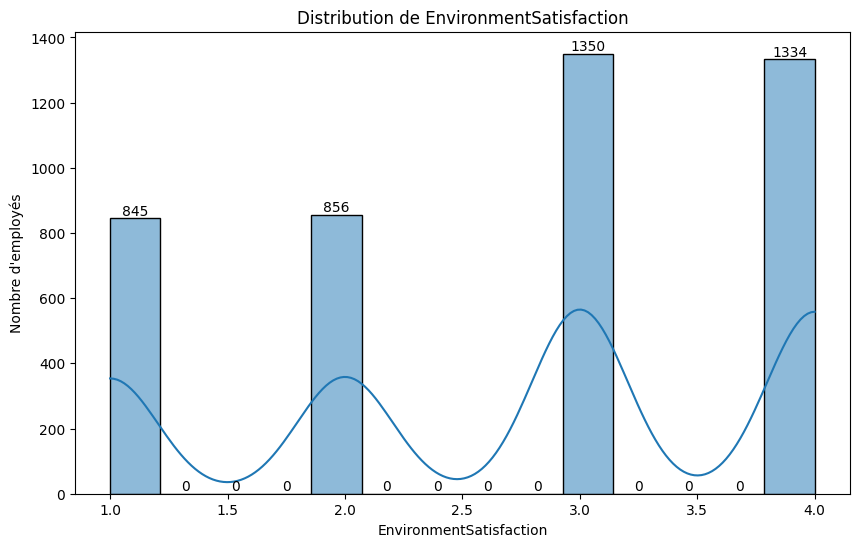

--------------------------------


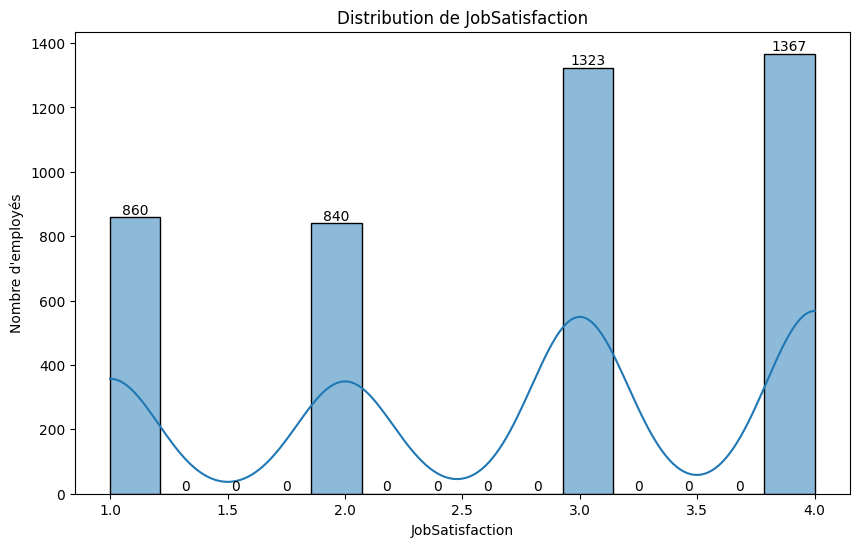

--------------------------------


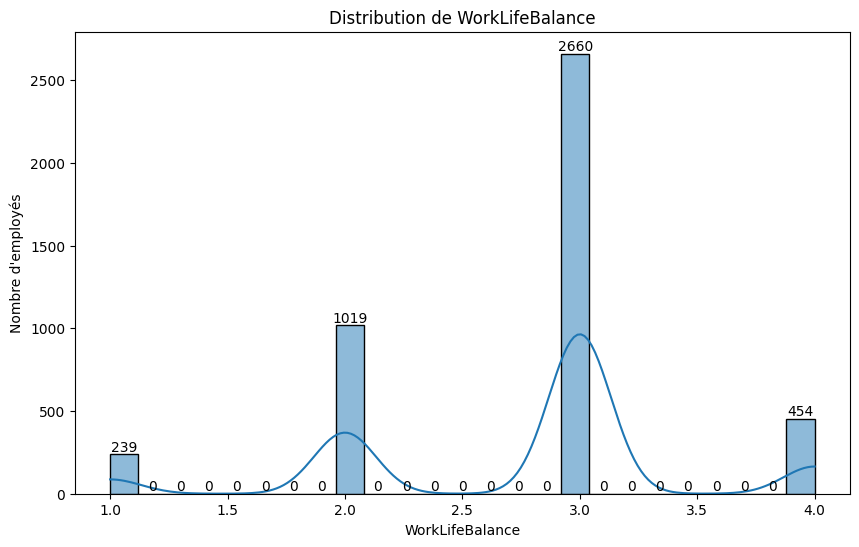

--------------------------------


,NumCompaniesWorked,TotalWorkingYears,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4391.0000,4401.0000,4385.0000,4390.0000,4372.0000
mean,2.6948,11.2799,2.7236,2.7282,2.7614
std,2.4989,7.7822,1.0928,1.1013,0.7062
min,0.0000,0.0000,1.0000,1.0000,1.0000
25%,1.0000,6.0000,2.0000,2.0000,2.0000
50%,2.0000,10.0000,3.0000,3.0000,3.0000
75%,4.0000,15.0000,4.0000,4.0000,3.0000
max,9.0000,40.0000,4.0000,4.0000,4.0000


In [142]:
missing_values_columns = ['NumCompaniesWorked', 'TotalWorkingYears', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
for column in missing_values_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(company_df[column], kde=True)
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Nombre d\'employés')

    for i in ax.containers:
        ax.bar_label(i)

    plt.show()
    print(DELIMITER)

company_df[missing_values_columns].describe()

Grâce à l'étude des colonnes concernées, nous pouvons observer qu'elles ont toutes une distribution asymétrique. En sachant cela, nous avons donc décider fait le choix d'utiliser la **médiane** pour remplacer les valeurs manquantes.<br>
La moyenne aurait été possible si la distribution des variables avait été symétrique, mais ce n'est pas le cas.

---

### 6. <a id='doublons'>Détection des valeurs dupliquées</a>

In [143]:
def check_duplicates(df):
    if df.duplicated().sum() > 0:
        print(f"Nombre de valeurs dupliquées : {df.duplicated().sum()}")
    else:
        print("Il n'y a pas de valeurs dupliquées dans le dataset")


check_duplicates(company_df)

Il n'y a pas de valeurs dupliquées dans le dataset


---

### 7. <a id='types'>Vérification des types de données</a>

#### 7.1. Colonnes numériques

In [144]:
numerical_columns = company_df.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns)

for column in numerical_columns:
    invalid_values = company_df[column].apply(lambda x: isinstance(x, (str)))
    if invalid_values.any():
        print(f"La colonne {column} contient des valeurs non numériques :")
        print(company_df[invalid_values][column])
        print(DELIMITER)

if not invalid_values.any():
    print("\nAucune valeur non numérique a été trouvée dans les colonnes numériques")

Index(['DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'Total_Hours'],
      dtype='object')

Aucune valeur non numérique a été trouvée dans les colonnes numériques


#### 7.2. Colonnes catégoriques

In [145]:
categorical_columns = company_df.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)
print("\n")

for column in categorical_columns:
    print(f"Vérification des valeurs uniques dans la colonne {column}")
    print(company_df[column].unique())
    print(DELIMITER)

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'EducationField',
       'JobRole'],
      dtype='object')


Vérification des valeurs uniques dans la colonne Age
['>44', '31-36', '37-43', '21-30', '<=20']
Categories (5, object): ['<=20' < '21-30' < '31-36' < '37-43' < '>44']
--------------------------------
Vérification des valeurs uniques dans la colonne Attrition
['No' 'Yes']
--------------------------------
Vérification des valeurs uniques dans la colonne BusinessTravel
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
--------------------------------
Vérification des valeurs uniques dans la colonne Department
['Sales' 'Research & Development' 'Human Resources']
--------------------------------
Vérification des valeurs uniques dans la colonne EducationField
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
--------------------------------
Vérification des valeurs uniques dans la colonne JobRole
['Healthcare Representative' 'Research Sc

In [146]:
print(f"Nombre de colonnes traitées : {len(numerical_columns) + len(categorical_columns)}")
print(f"Nombre de colonnes dans le dataset : {company_df.shape[1]}")

Nombre de colonnes traitées : 24
Nombre de colonnes dans le dataset : 24


Nous pouvons voir qu'il y a le même nombre entre les colonnes traitées et celles dans le dataset, et que donc toutes les variables ont été traitées.

---

### 8. <a id='pipeline'>Pipeline de traitement des données</a>

In [147]:
num_features = numerical_columns.tolist()
cat_features = categorical_columns.tolist()

# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline pour les variables catégoriques
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline d'encodage binaire d'Attrition
attrition_pipeline = Pipeline([
    ('bool_transform', FunctionTransformer(lambda x: x == 'Yes', validate=False))
])

# Pipeline globale
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, [col for col in cat_features if col != 'Attrition']),
    ('cat_specific', attrition_pipeline, ['Attrition'])
])

# Appliquer la transformation sur les données d'origine
company_transformed_df = preprocessor.fit_transform(company_df)

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_one_hot_columns = cat_encoder.get_feature_names_out([col for col in cat_features if col != 'Attrition']).tolist()

# Ajouter la colonne `Attrition` traitée
final_columns = num_features + cat_one_hot_columns + ['Attrition']

# Créer le DataFrame transformé
processed_df = pd.DataFrame(company_transformed_df, columns=final_columns)

# Afficher les premières lignes du DataFrame transformé
processed_df.head()

,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,...,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Attrition
0,-0.3939,-0.8917,-0.9615,1.4051,-0.6785,-1.1506,-0.9320,-1.3221,2.4834,-0.9810,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0996,-1.8684,-0.9615,-0.4917,-1.0795,2.1293,0.2420,-0.6789,0.1557,-0.3279,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
2,0.9634,1.0618,1.7496,2.7251,-0.6785,-0.0573,2.5900,-0.8075,-0.6202,-0.3279,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
3,-0.8875,2.0385,0.8459,0.3863,0.1236,-1.1506,2.5900,0.2216,1.7075,0.1619,...,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0996,-1.8684,-0.9615,-0.8841,0.5246,-0.8772,1.4160,-0.2930,-0.6202,-0.1646,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


On vient vérifier qu'il n'y a plus de valeurs manquantes dans le dataset :

Il n'y a pas de valeurs manquantes dans le dataset


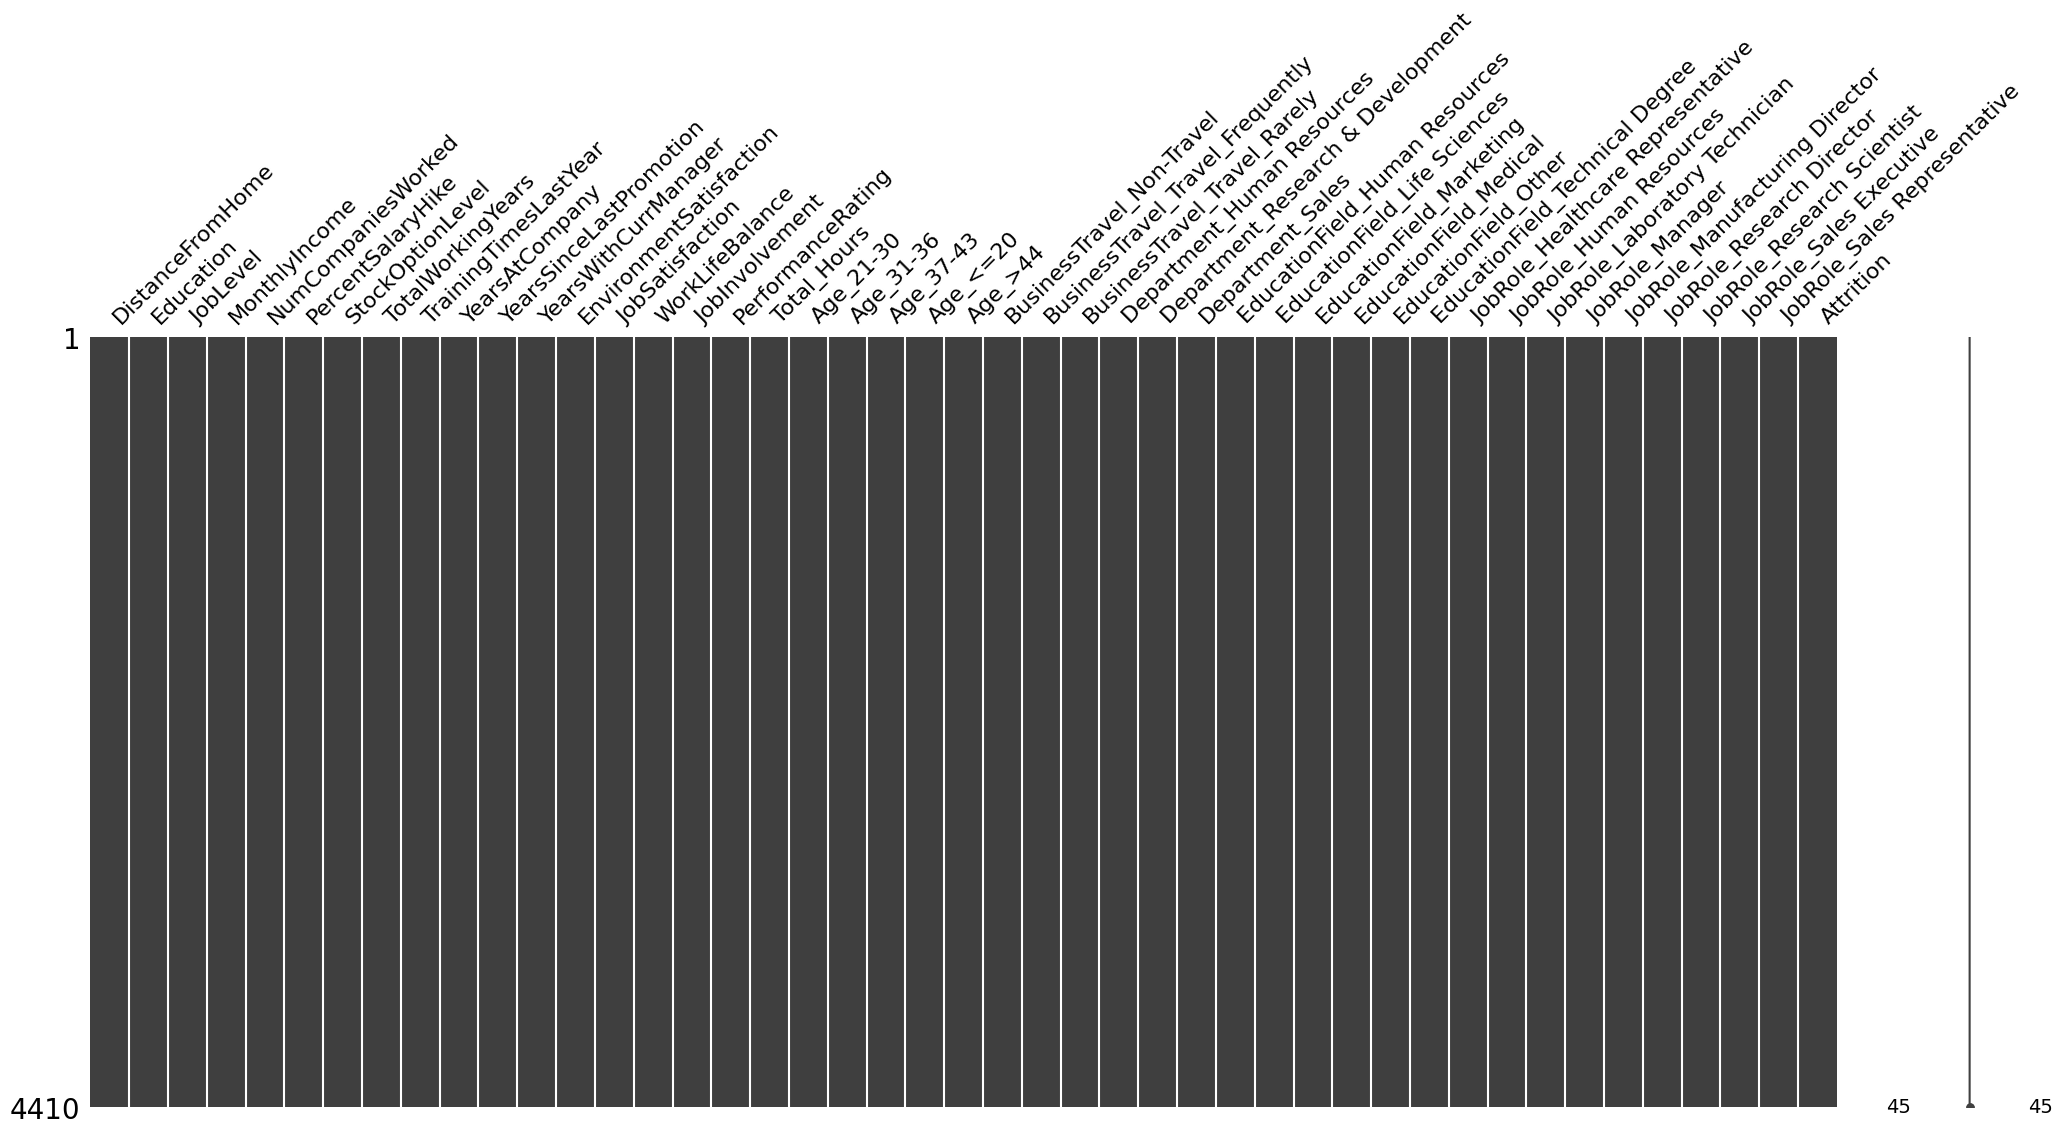

,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,...,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Attrition
count,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,...,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000,4410.0000
mean,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,...,0.0891,0.0354,0.1762,0.0694,0.0986,0.0544,0.1986,0.2218,0.0565,0.1612
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,...,0.2849,0.1847,0.3810,0.2541,0.2982,0.2269,0.3990,0.4155,0.2308,0.3678
min,-1.0109,-1.8684,-0.9615,-1.1673,-1.0795,-1.1506,-0.9320,-1.4507,-2.1720,-1.1443,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,-0.8875,-0.8917,-0.9615,-0.7632,-0.6785,-0.8772,-0.9320,-0.6789,-0.6202,-0.6545,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,-0.2705,0.0850,-0.0578,-0.3366,-0.2774,-0.3306,0.2420,-0.1643,0.1557,-0.3279,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.5932,1.0618,0.8459,0.3988,0.5246,0.7627,0.2420,0.4789,0.1557,0.3252,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,2.4441,2.0385,2.6533,2.8676,2.5297,2.6759,2.5900,3.6949,2.4834,5.3869,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [148]:
check_missing_values(processed_df)
processed_df.describe()

Toutes les colonnes sont biens remplies, nous pouvons donc continuer.

---

### 9. <a id='eda'>EDA</a>

À présent, nous allons réaliser une analyse exploratoire des données (EDA - Exploratory Data Analysis) pour mieux comprendre les différentes variables et leur impact sur l'attrition des employés.

#### 9.1. Analyse des distributions des variables

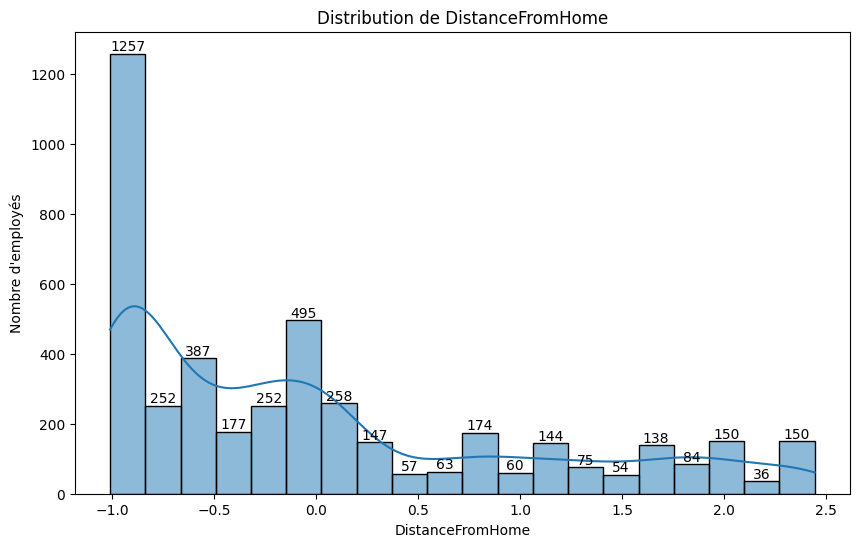

--------------------------------


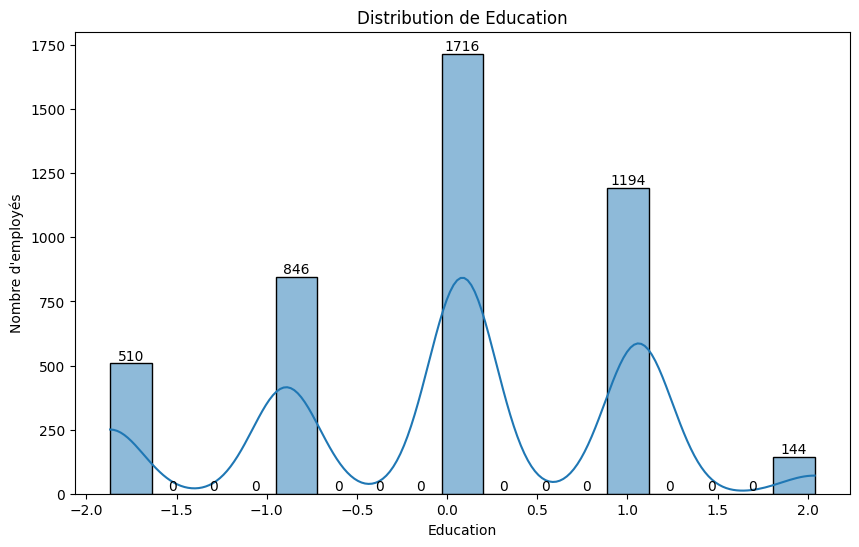

--------------------------------


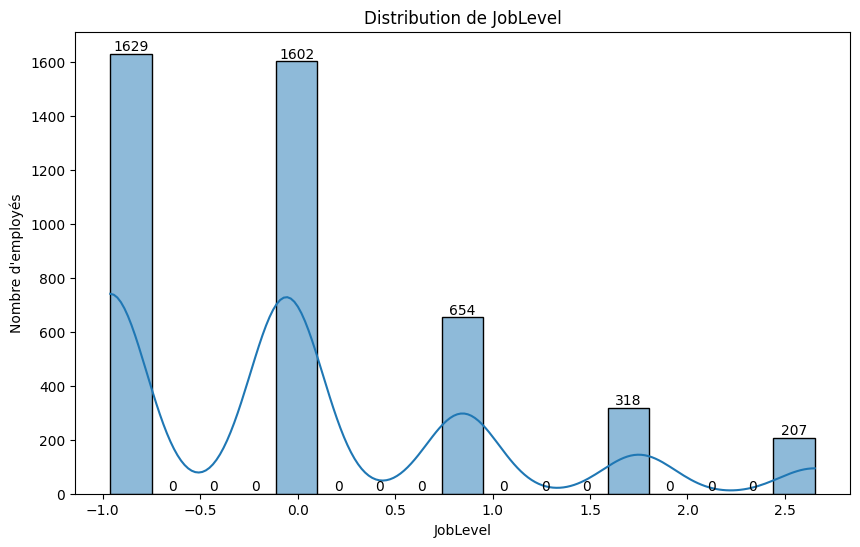

--------------------------------


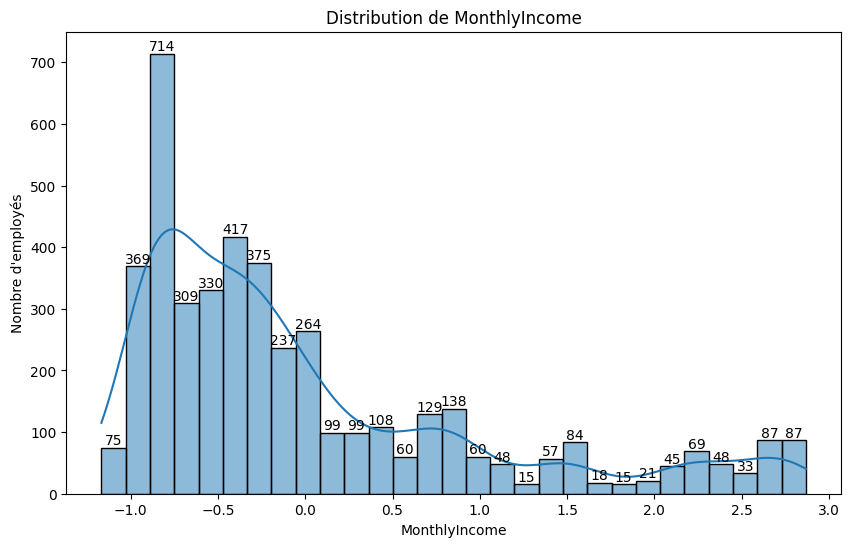

--------------------------------


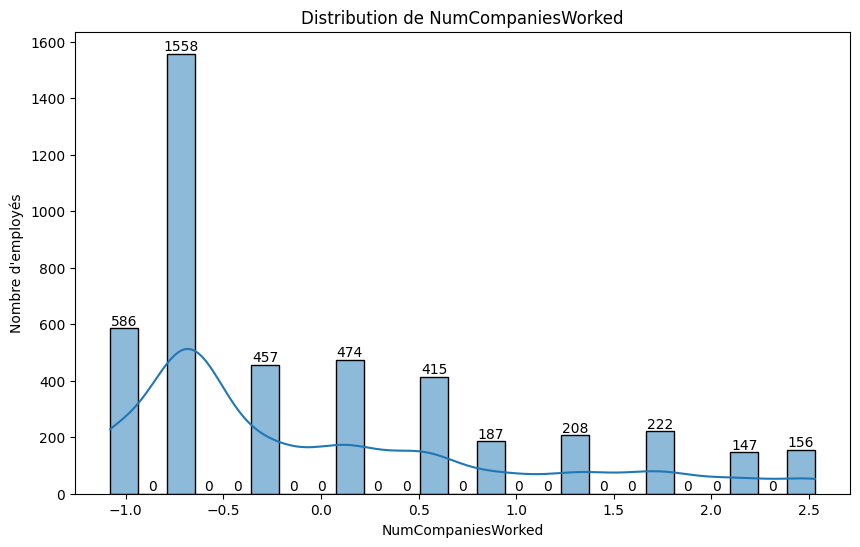

--------------------------------


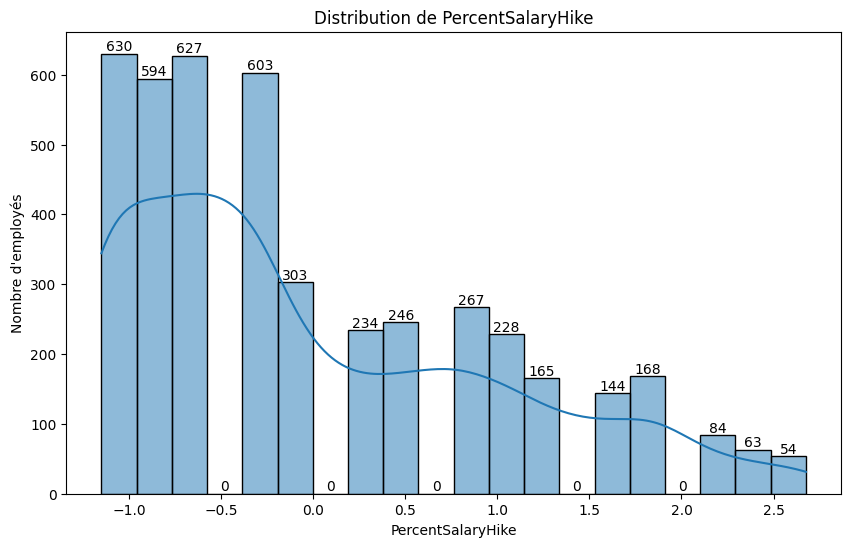

--------------------------------


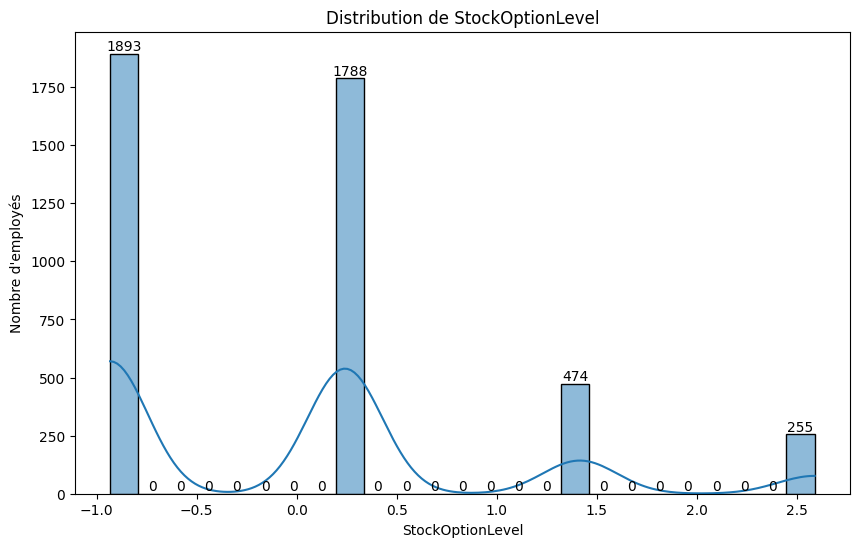

--------------------------------


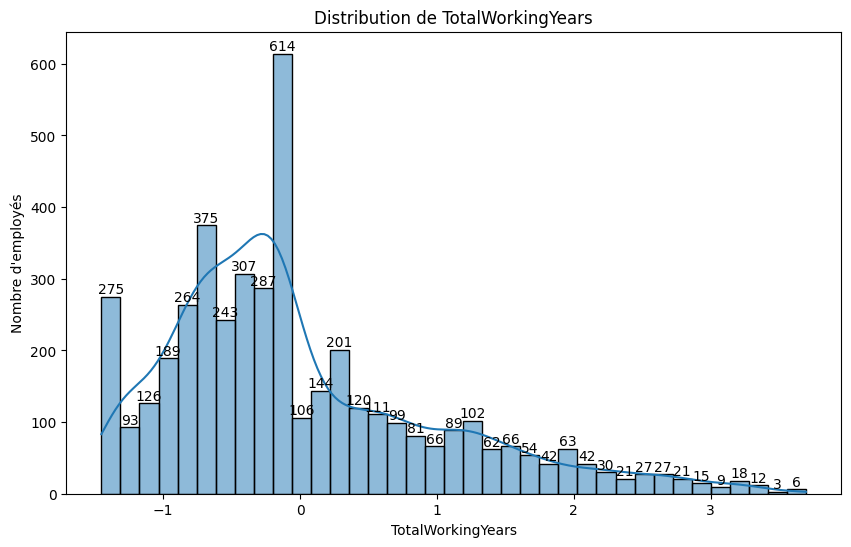

--------------------------------


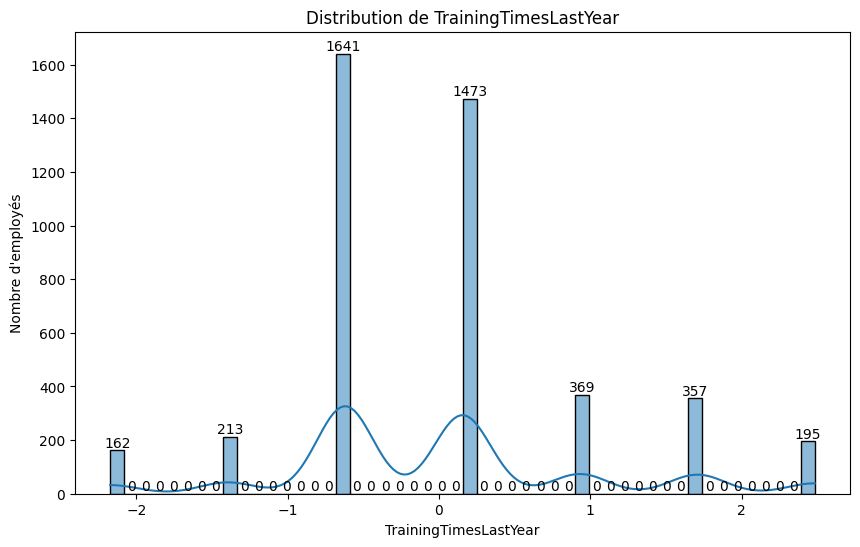

--------------------------------


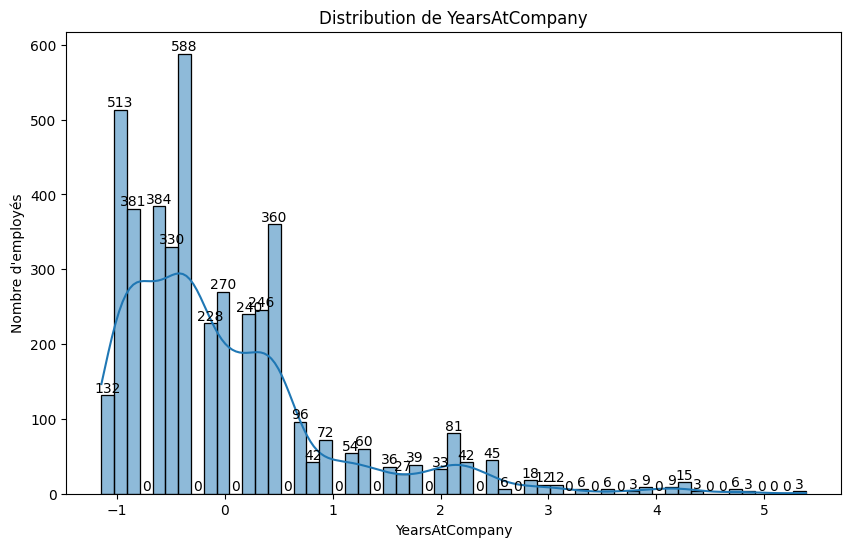

--------------------------------


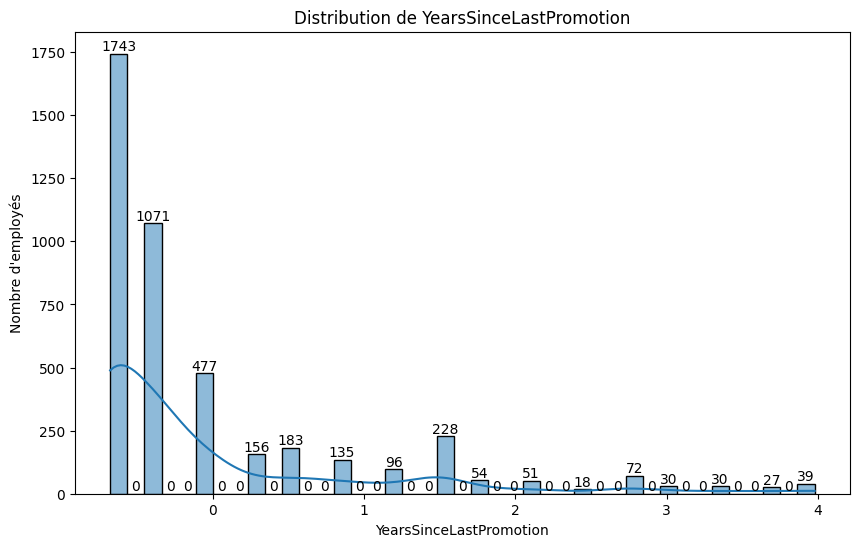

--------------------------------


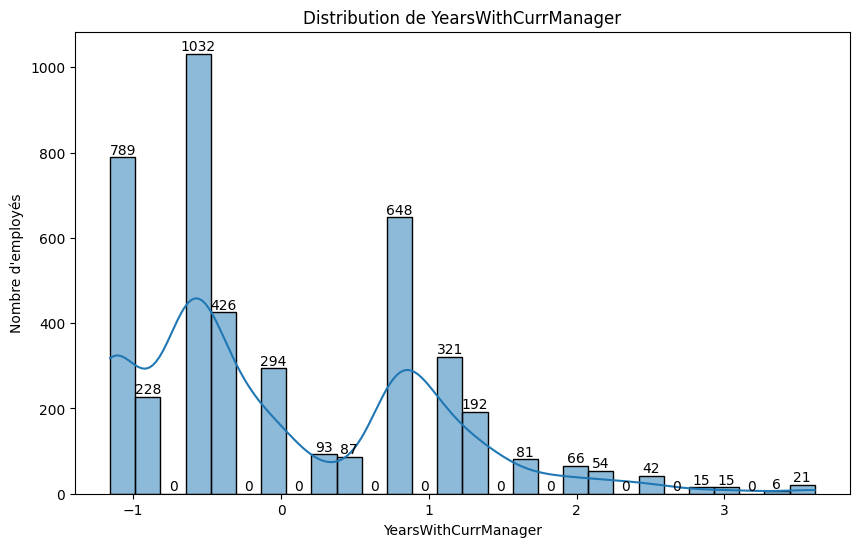

--------------------------------


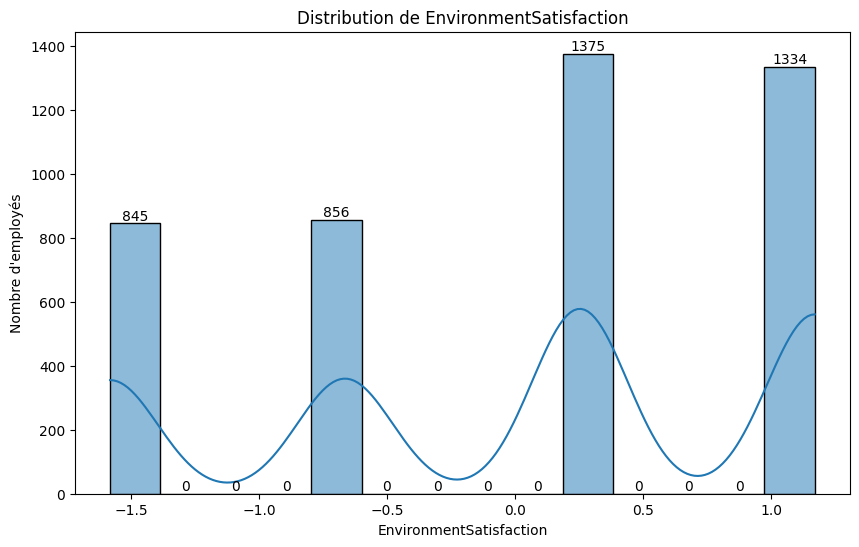

--------------------------------


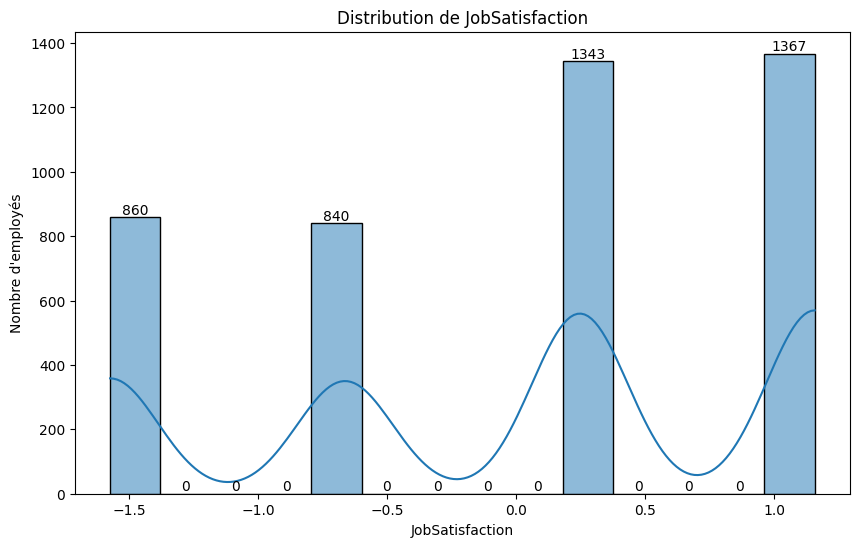

--------------------------------


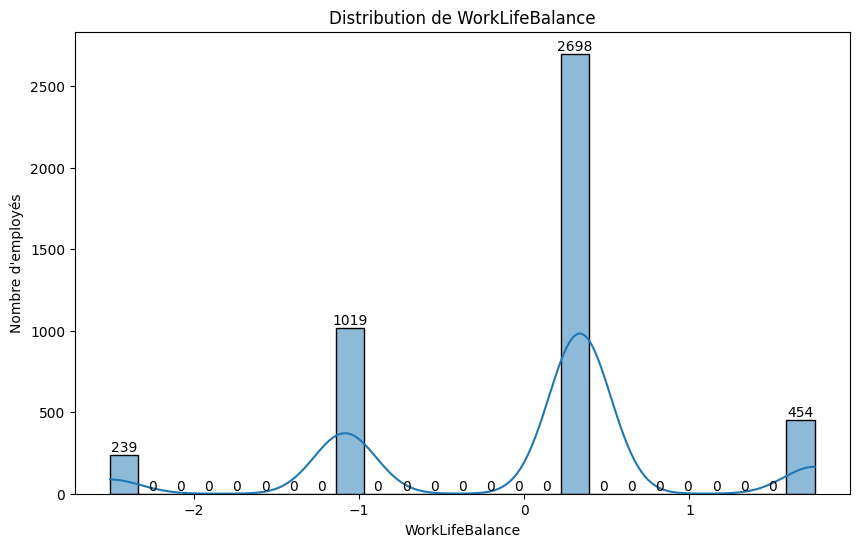

--------------------------------


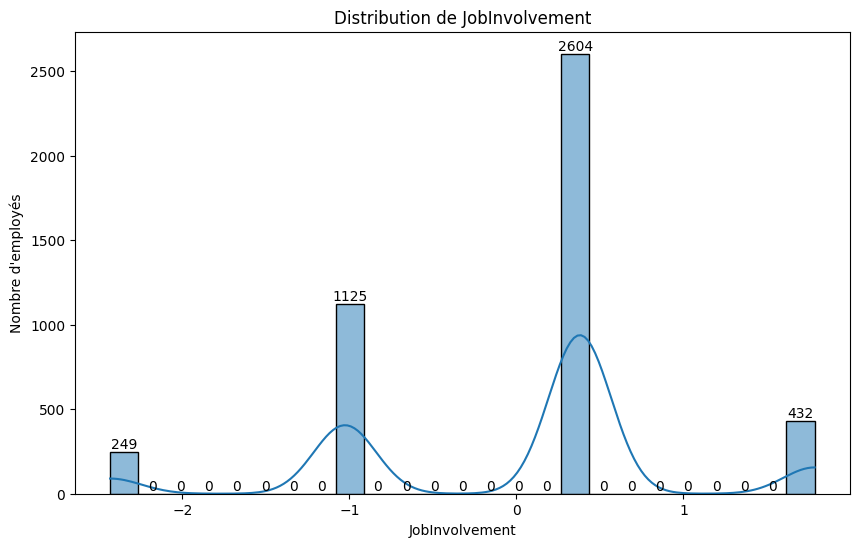

--------------------------------


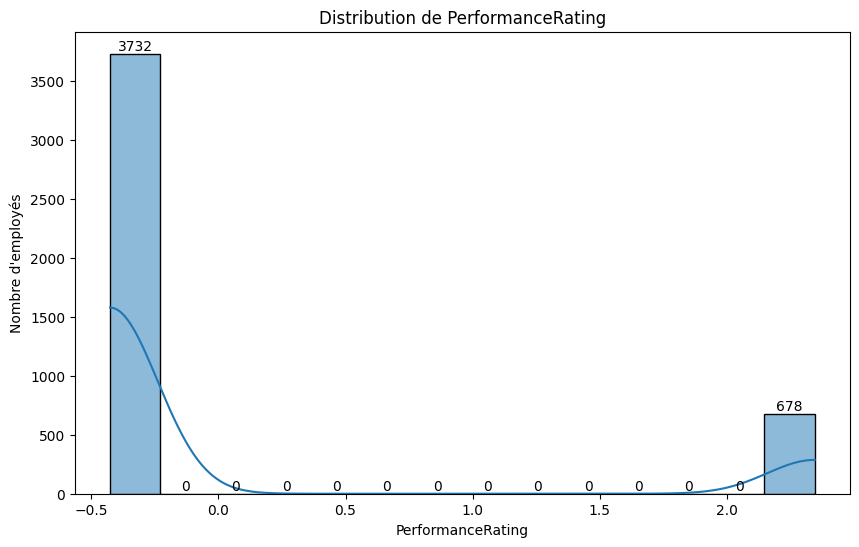

--------------------------------


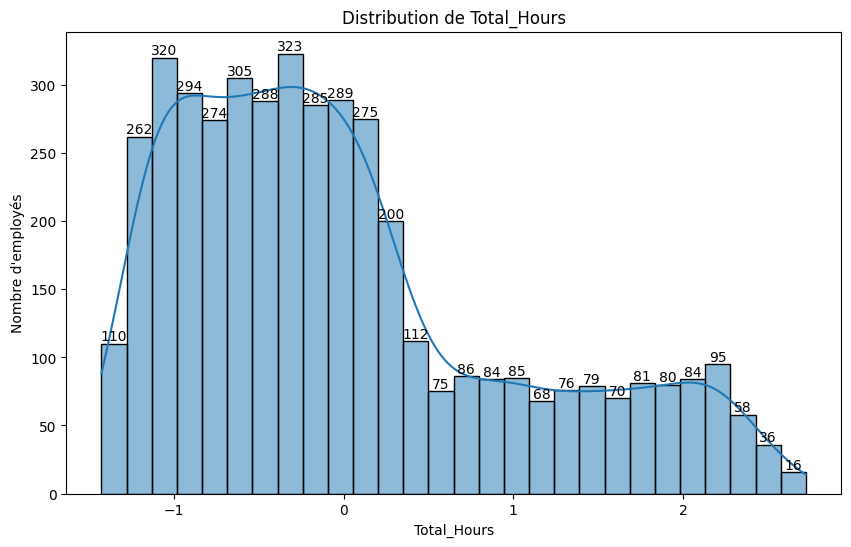

--------------------------------


In [149]:
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(processed_df[column], kde=True)
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Nombre d\'employés')

    for i in ax.containers:
        ax.bar_label(i)

    plt.show()
    print(DELIMITER)

Les graphiques ci-dessus correspondent à la distribution des différentes variables numériques de notre dataset.

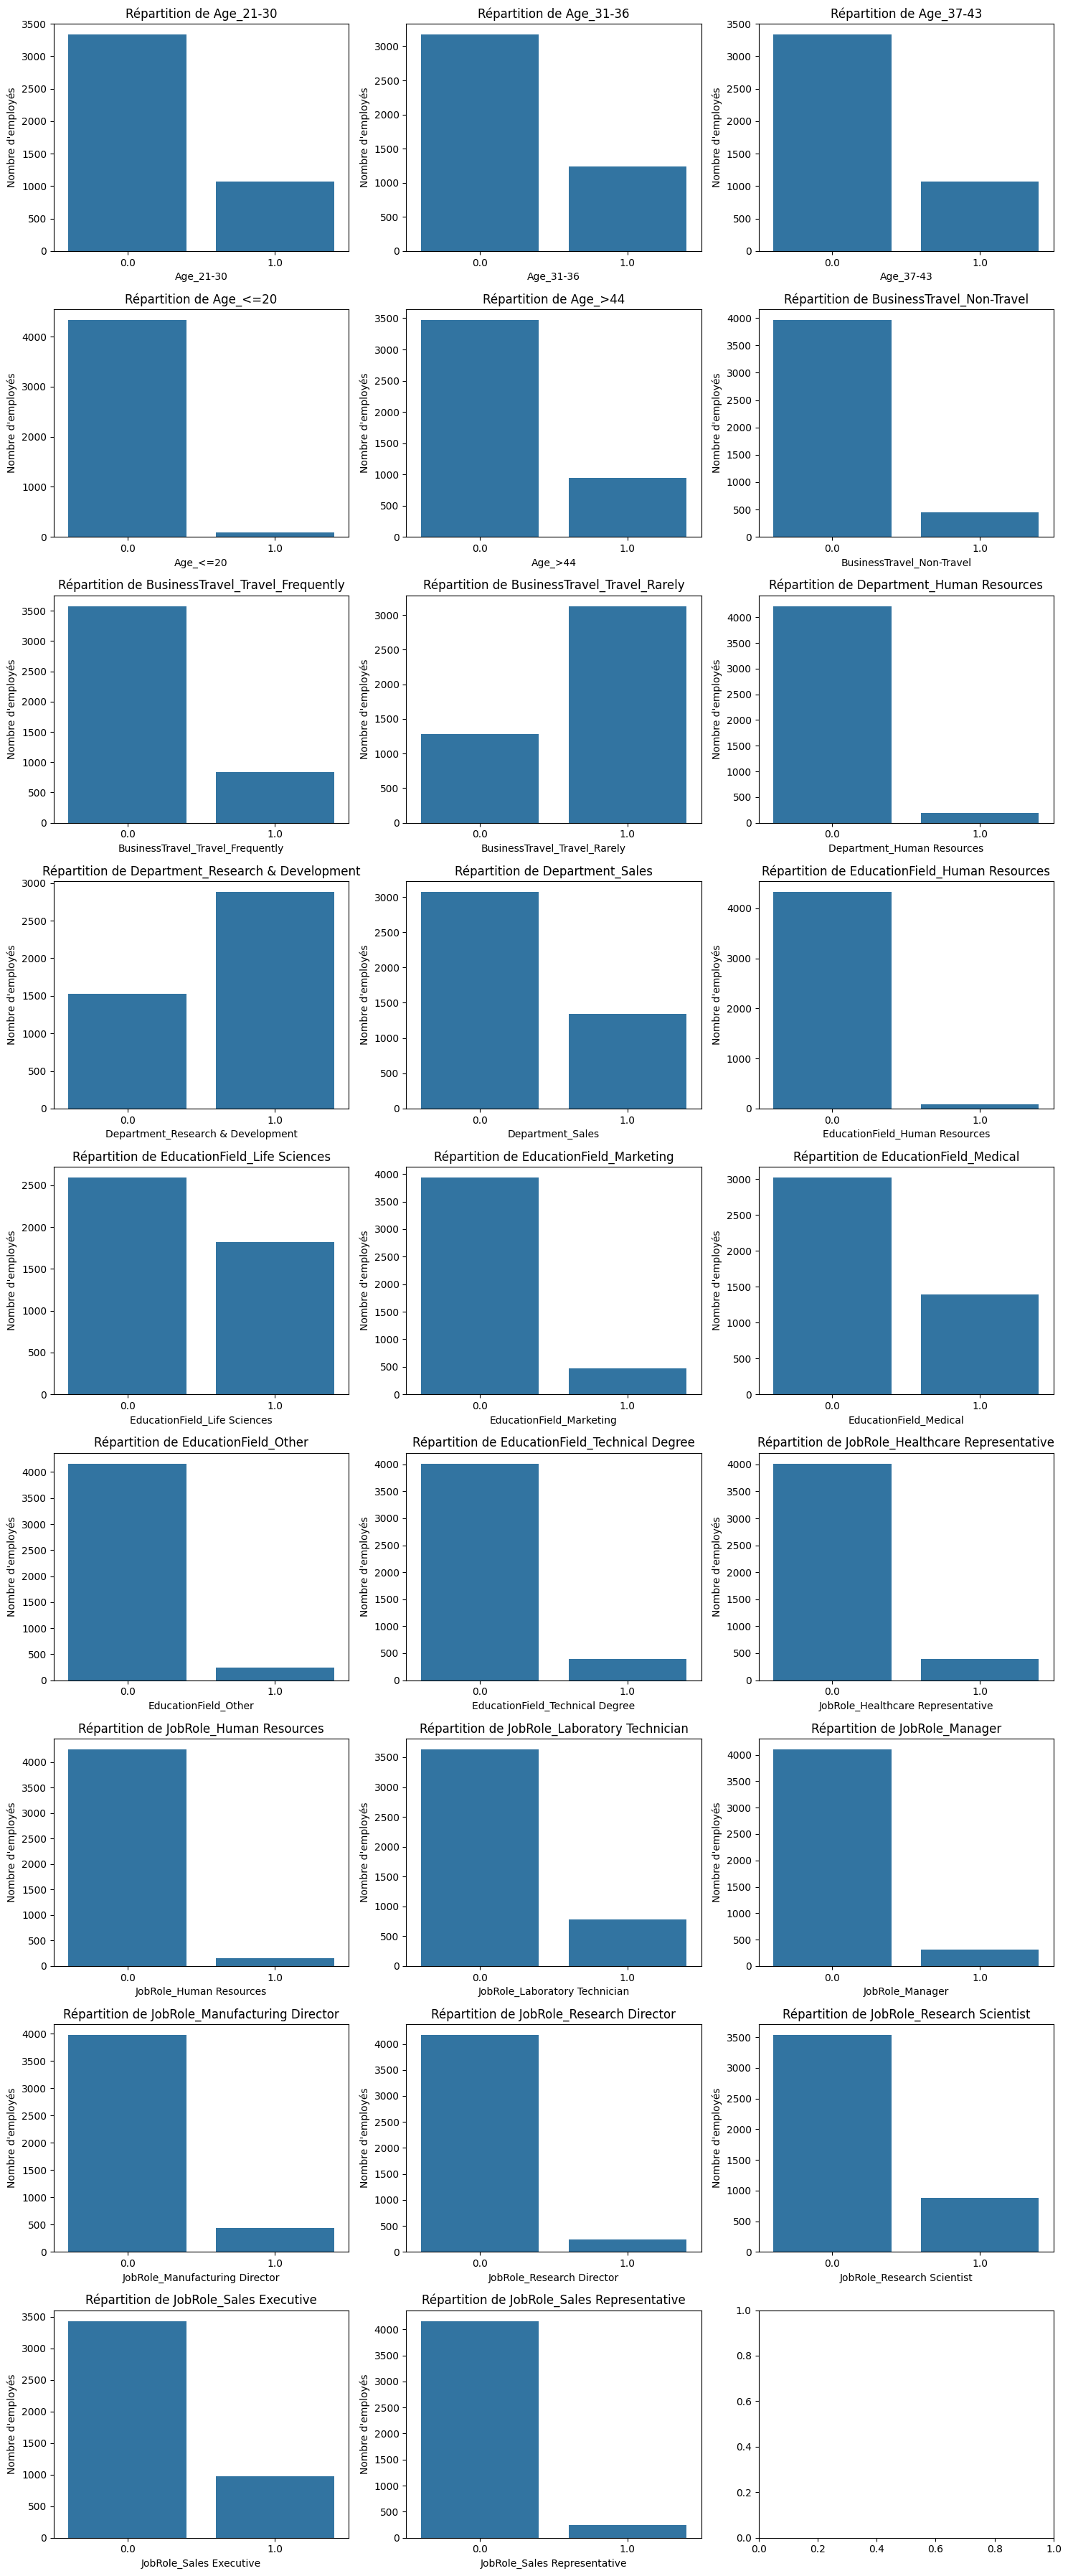

In [150]:
# Définir la disposition :
num_cols = 3
num_rows = (len(cat_one_hot_columns) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

axes = axes.flatten() if num_rows > 1 else [axes]

for i, column in enumerate(cat_one_hot_columns):
    sns.countplot(data=processed_df, x=column, ax=axes[i])
    axes[i].set_title(f'Répartition de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Nombre d\'employés')

# Ajuster l'espace entre les sous-graphiques
plt.tight_layout()
plt.show()

Nous remarquons que les variables numériques suivent une distribution normale, ce qui est un bon point pour l'entraînement des modèles. <br>
Pour les variables catégoriques, nous pouvons voir que les employés célibataires ont plus tendance à quitter l'entreprise. De plus, les employés voyageant fréquemment ont également plus de chances de quitter l'entreprise.

──────────────────────────────────────────────────

#### 9.2. Matrice de corrélation

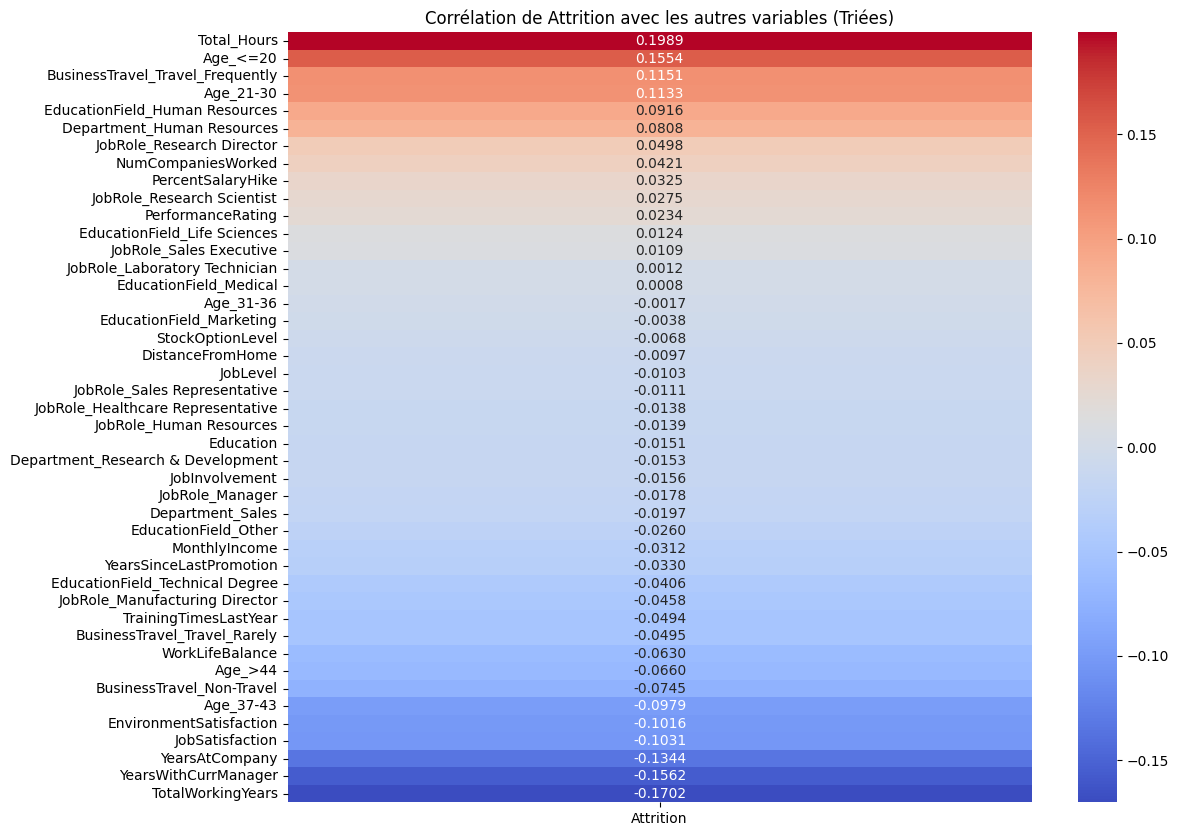

In [151]:
corr_matrix = processed_df.corr()

corr_attrition = corr_matrix.loc['Attrition'].drop('Attrition')

corr_attrition_sorted = corr_attrition.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_attrition_sorted.to_frame(), annot=True, fmt='.4f', cmap='coolwarm', cbar=True)

plt.title('Corrélation de Attrition avec les autres variables (Triées)')
plt.show()

Nous remarquons que certaines variables ont un coefficient positif vis-à-vis de notre variable cible. Nous allons afficher la répartition de l'attrition selon ces variables.

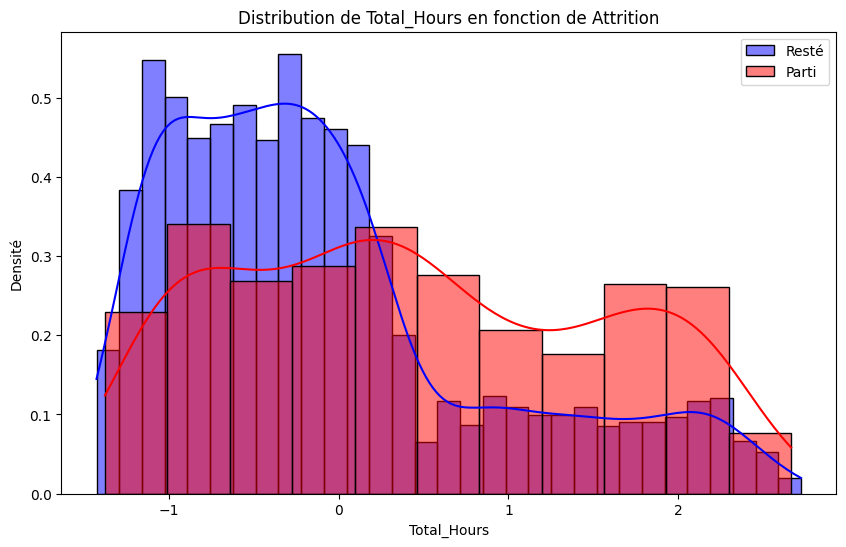

--------------------------------


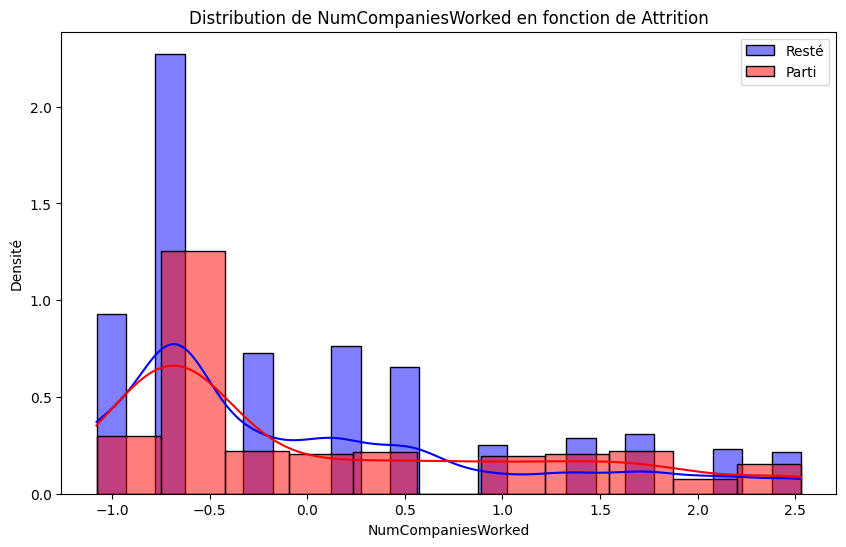

--------------------------------


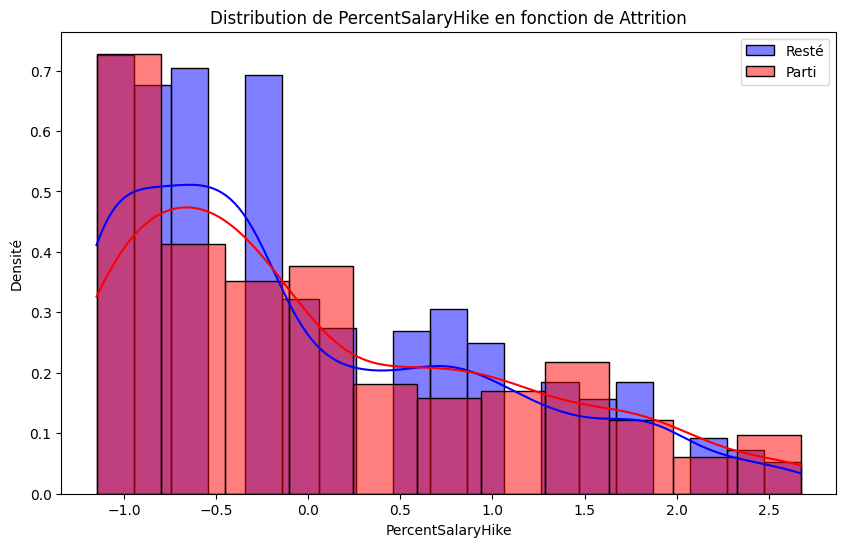

--------------------------------


In [152]:
def feature_distribution_with_attrition(correlation_columns):
    for column in correlation_columns:
        plt.figure(figsize=(10, 6))

        # Séparer les données en fonction de 'Attrition' (0 = resté, 1 = parti)
        sns.histplot(processed_df[processed_df['Attrition'] == 0][column], kde=True, color='blue', label='Resté', stat='density')
        sns.histplot(processed_df[processed_df['Attrition'] == 1][column], kde=True, color='red', label='Parti', stat='density')

        plt.title(f'Distribution de {column} en fonction de Attrition')
        plt.xlabel(column)
        plt.ylabel('Densité')
        plt.legend()
        plt.show()
        print(DELIMITER)

feature_distribution_with_attrition(['Total_Hours', 'NumCompaniesWorked', 'PercentSalaryHike'])

Nous remarquons que pour une approche linéaire, les variables les plus corrélées avec l'attrition sont : `Total_Hours`, `MaritalStatus_Single`, `BusinessTravel_Travel_Frequently`, `EducationField_Human Resources`, `Department_Human Resources`, `JobRole_Research Director` et `NumCompaniesWorked`.

Cependant, il faut faire attention car il s'agit seulement des relations linéaires, il est possible que d'autres variables aient un impact sur l'attrition des employés.

──────────────────────────────────────────────────

#### 9.3. Étude des outliers

À présent, nous allons étudier les différents outliers présent, afin de savoir si notre jeu de données est cohérent. Nous allons utiliser la méthode de l'écart interquartile (IQR).

Résumé des valeurs aberrantes

- DistanceFromHome: 0 outliers détectés
- Education: 0 outliers détectés
- JobLevel: 0 outliers détectés
- MonthlyIncome: 342 outliers détectés
- NumCompaniesWorked: 156 outliers détectés
- PercentSalaryHike: 0 outliers détectés
- StockOptionLevel: 255 outliers détectés
- TotalWorkingYears: 189 outliers détectés
- TrainingTimesLastYear: 714 outliers détectés
- YearsAtCompany: 312 outliers détectés
- YearsSinceLastPromotion: 321 outliers détectés
- YearsWithCurrManager: 42 outliers détectés
- EnvironmentSatisfaction: 0 outliers détectés
- JobSatisfaction: 0 outliers détectés
- WorkLifeBalance: 0 outliers détectés
- JobInvolvement: 0 outliers détectés
- PerformanceRating: 678 outliers détectés
- Total_Hours: 119 outliers détectés
- Age_21-30: 1074 outliers détectés
- Age_31-36: 0 outliers détectés
- Age_37-43: 1074 outliers détectés
- Age_<=20: 84 outliers détectés
- Age_>44: 942 outliers détectés
- BusinessTravel_Non-Travel: 450 outliers détectés
- Busines

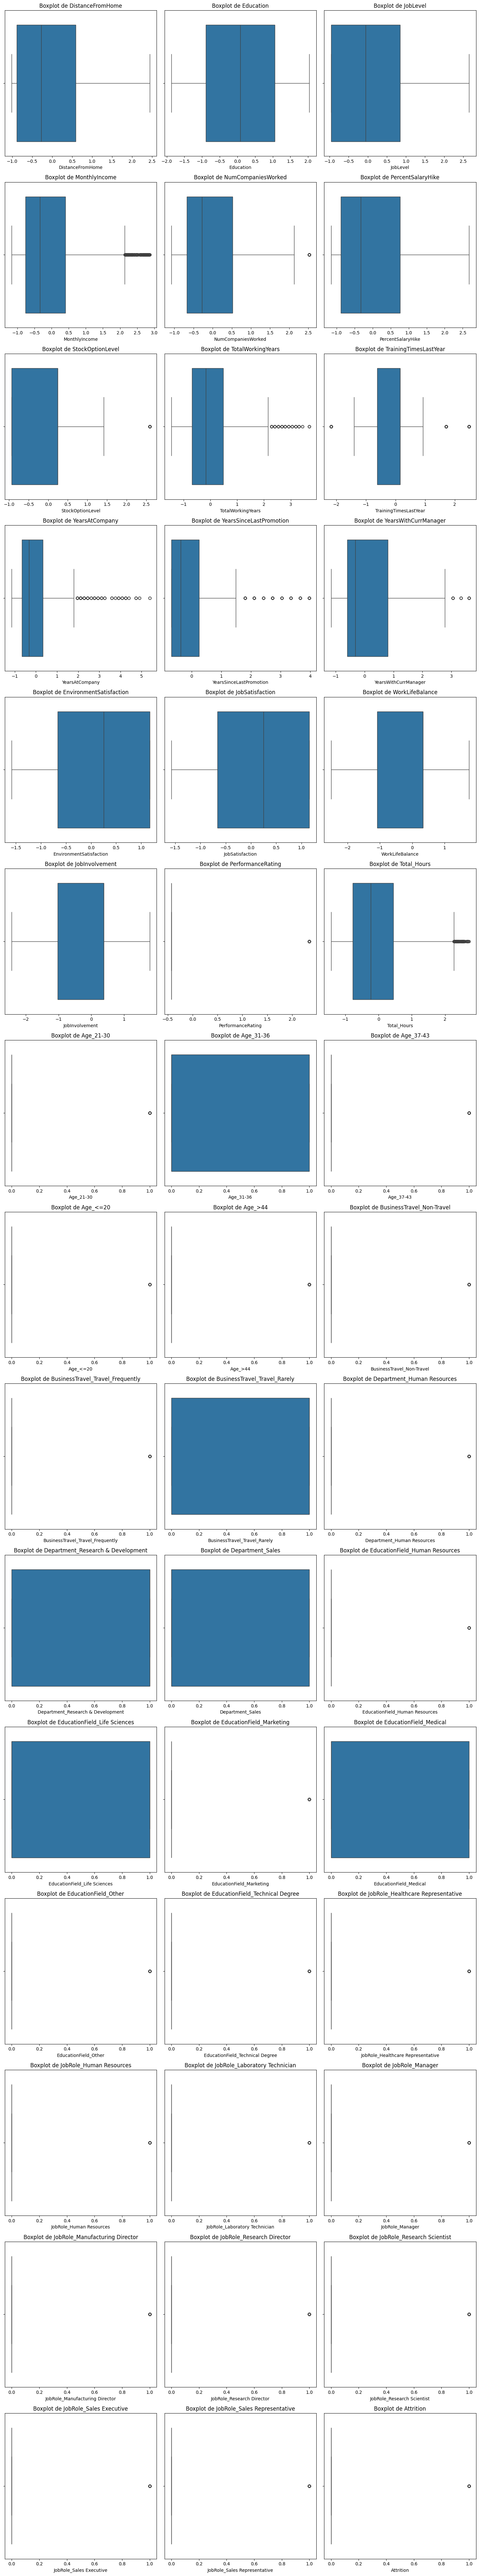

In [153]:
# Détection des outliers avec l'IQR
def outliers_list(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

def detect_outliers(data, numerical_columns, multiplier=1.5):
    outlier_dict = {}
    print("Résumé des valeurs aberrantes\n")

    for column in numerical_columns:
        outliers = outliers_list(data, column, multiplier)
        outlier_count = len(outliers)
        outlier_dict[column] = outliers

        print(f"- {column}: {outlier_count} outliers détectés")

    return outlier_dict

def plot_boxplots(data, numerical_columns):
    num_cols = len(numerical_columns)
    fig, axes = plt.subplots(nrows=(num_cols // 3), ncols=3, figsize=(15, 5 * ((num_cols // 3) + 1)))

    for i, column in enumerate(numerical_columns):
        row, col = divmod(i, 3)
        sns.boxplot(x=data[column], ax=axes[row, col])
        axes[row, col].set_title(f'Boxplot de {column}')

    plt.tight_layout()
    plt.show()

numerical_columns = processed_df.select_dtypes(include=['number']).columns
outliers_detected = detect_outliers(processed_df, numerical_columns)
plot_boxplots(processed_df, numerical_columns)

À la vue des résultats, nous avons décidé de conserver les valeurs qui sortent de l'ordinaire car il s'agit de valeurs réalistes, bien qu'atypiques, et non incohérentes.

---

### 10. <a id='model-training-evaluation-optimization'>Entraînement, évaluation et optimisation des modèles</a>

Afin d'obtenir un résultat précis, nous allons utiliser la classe `StratifiedShuffleSplit` pour obtenir des splits stratifiés. On va ensuite entraîner différents modèles de classification pour prédire l'attrition des employés.

#### 10.1. Définition de la méthode d'entraînement et d'évaluation des modèles

In [154]:
def train_and_evaluate_model(models_selected, n_split):
    stratified_split = StratifiedShuffleSplit(n_splits=n_split, test_size=0.2, random_state=42)

    # Initialisation des dictionnaires pour stocker les résultats
    accuracies = {}
    roc_aucs = {}
    f1_scores = {}
    precisions = {}
    recalls = {}
    training_time_taken = {}
    predict_time_taken = {}

    # Initialisation des listes pour chaque modèle
    for model in models_selected:
        model_name = model.__class__.__name__
        accuracies[model_name] = []
        roc_aucs[model_name] = []
        f1_scores[model_name] = []
        precisions[model_name] = []
        recalls[model_name] = []
        training_time_taken[model_name] = []
        predict_time_taken[model_name] = []

    for train_index, test_index in stratified_split.split(processed_df, processed_df['Attrition']):
        strat_train_set = processed_df.loc[train_index]
        strat_test_set = processed_df.loc[test_index]

        data_train_set = strat_train_set.drop(['Attrition'], axis=1)
        data_labels = strat_train_set['Attrition'].copy()
        data_test_set = strat_test_set.drop(['Attrition'], axis=1)
        data_labels_test = strat_test_set['Attrition'].copy()

        # Entraînement et évaluation de chaque modèle
        for model in models_selected:
            model_name = model.__class__.__name__

            start_time = time.time()
            model.fit(data_train_set, data_labels)
            end_time = time.time()

            start_time_2 = time.time()
            y_pred = model.predict(data_test_set)
            end_time_2 = time.time()

            y_proba = model.predict_proba(data_test_set)[:, 1]

            # Évaluation des performances pour ce split
            accuracy = accuracy_score(data_labels_test, y_pred)
            roc_auc = roc_auc_score(data_labels_test, y_proba)
            f1 = f1_score(data_labels_test, y_pred)
            precision = precision_score(data_labels_test, y_pred)
            recall = recall_score(data_labels_test, y_pred)

            accuracies[model_name].append(accuracy)
            roc_aucs[model_name].append(roc_auc)
            f1_scores[model_name].append(f1)
            precisions[model_name].append(precision)
            recalls[model_name].append(recall)
            training_time_taken[model_name].append(end_time - start_time)
            predict_time_taken[model_name].append(end_time_2 - start_time_2)

    # Création du DataFrame des résultats
    results_df = pd.DataFrame({
        'Model': list(accuracies.keys()),
        'Average Accuracy': [np.mean(acc) for acc in accuracies.values()],
        'Average ROC AUC': [np.mean(roc) for roc in roc_aucs.values()],
        'Average F1 Score': [np.mean(f1) for f1 in f1_scores.values()],
        'Average Precision': [np.mean(prec) for prec in precisions.values()],
        'Average Recall': [np.mean(rec) for rec in recalls.values()],
        'Average Training Time (s)': [np.mean(time_t) for time_t in training_time_taken.values()],
        'Average Predict Time (s)': [np.mean(time_t) for time_t in predict_time_taken.values()]
    })

    # Création d'un DataFrame détaillé pour le boxplot
    metrics_data = []
    for model_name in accuracies.keys():
        for i in range(n_split):
            metrics_data.append(['Accuracy', model_name, accuracies[model_name][i]])
            metrics_data.append(['ROC AUC', model_name, roc_aucs[model_name][i]])
            metrics_data.append(['F1 Score', model_name, f1_scores[model_name][i]])
            metrics_data.append(['Precision', model_name, precisions[model_name][i]])
            metrics_data.append(['Recall', model_name, recalls[model_name][i]])

    df_metrics = pd.DataFrame(metrics_data, columns=['Metric', 'Model', 'Value'])
    metrics_list = ['Accuracy', 'ROC AUC', 'F1 Score', 'Precision', 'Recall']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics_list, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x='Model', y='Value', data=df_metrics[df_metrics['Metric'] == metric], palette="Set2")
        plt.title(f"Boxplot de {metric}")
        plt.xlabel("Modèle")
        plt.ylabel(metric)
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    print("\nRésultats finaux :")
    return results_df

──────────────────────────────────────────────────

#### 10.2. Entraînement et évaluation des modèles

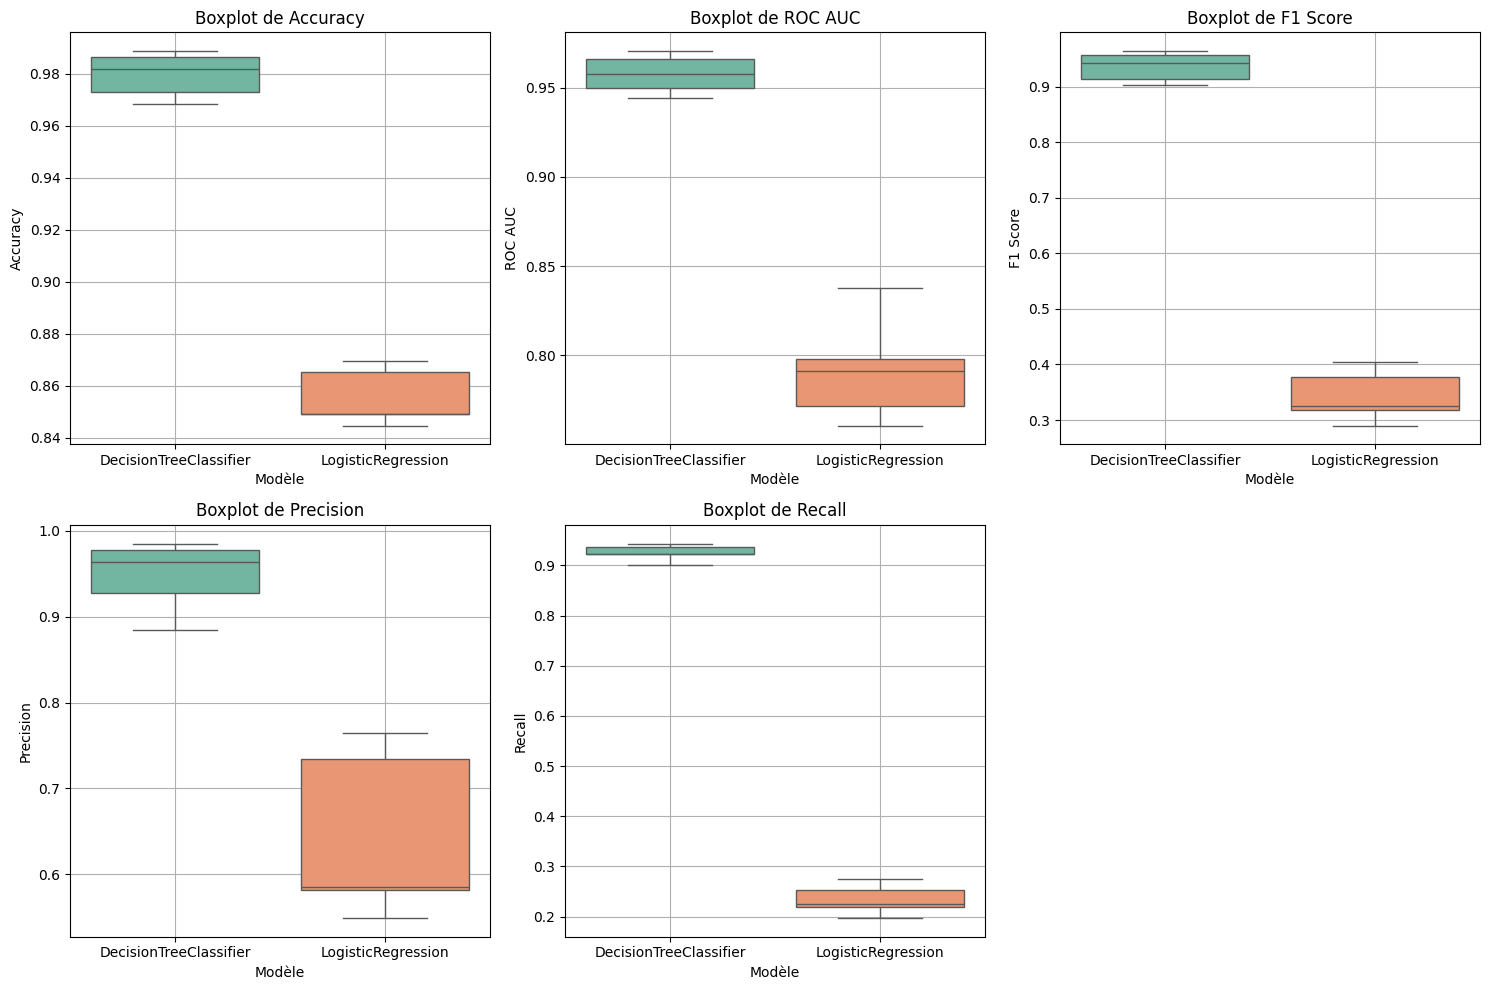


Résultats finaux :


,Model,Average Accuracy,Average ROC AUC,Average F1 Score,Average Precision,Average Recall,Average Training Time (s),Average Predict Time (s)
0,DecisionTreeClassifier,0.9796,0.9577,0.9362,0.9478,0.9254,0.0293,0.0014
1,LogisticRegression,0.8556,0.7919,0.3428,0.6430,0.2338,0.0218,0.0013


In [155]:
decision_tree_model = DecisionTreeClassifier(random_state=18)
logistic_model = LogisticRegression(random_state=18)
pd.set_option('display.float_format', '{:.4f}'.format)

models = [decision_tree_model, logistic_model]

results_df = train_and_evaluate_model(models, 5)

results_df

L’évaluation des modèles montre que `DecisionTreeClassifier` surpasse `LogisticRegression` sur plusieurs aspects, ce qui en fait le meilleur choix des deux.<br>
Nous allons donc utiliser les hyperparamètres afin de l’optimiser davantage et améliorer ses performances.

──────────────────────────────────────────────────

#### 10.3. Optimisation du meilleur modèle

Meilleurs paramètres pour DecisionTreeClassifier : {'max_depth': None, 'min_samples_leaf': 1, 'splitter': 'random'}
Score (Accuracy) : 0.9916


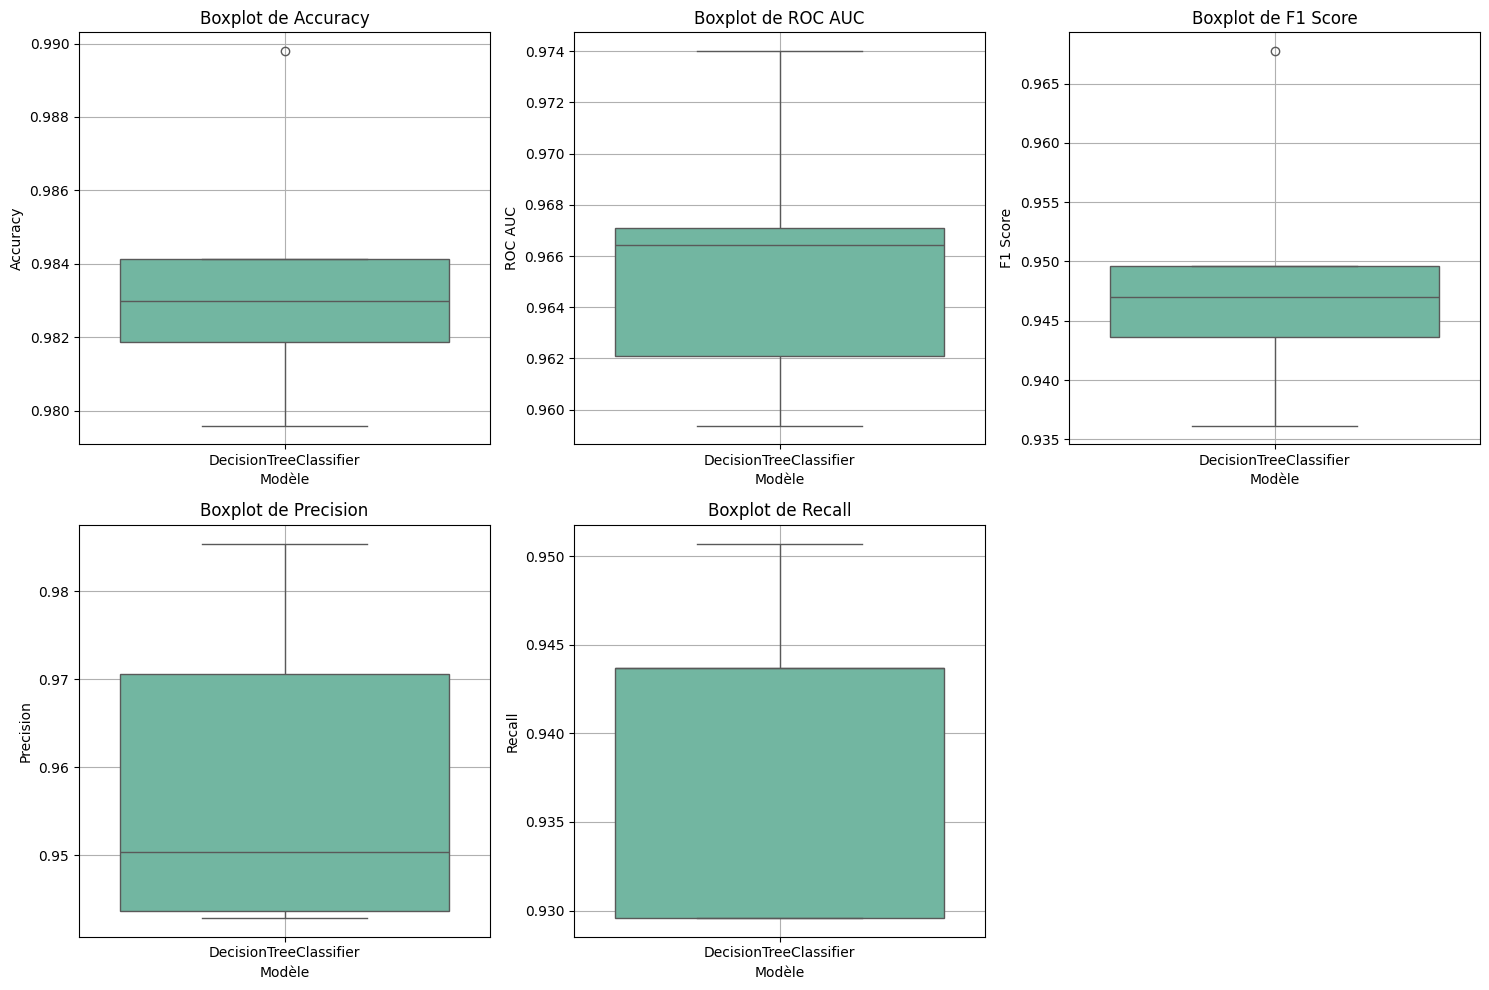


Résultats finaux :


,Model,Average Accuracy,Average ROC AUC,Average F1 Score,Average Precision,Average Recall,Average Training Time (s),Average Predict Time (s)
0,DecisionTreeClassifier,0.9837,0.9658,0.9488,0.9586,0.9394,0.0132,0.0019


In [156]:
param_grids = {
    "DecisionTreeClassifier": {
        "max_depth": [5, 10, 20, 25, None],
        'splitter': ['best', 'random'],
        'min_samples_leaf': [1, 2, 5, 10]
    }
}
best_params = {}
best_scores = {}
model = DecisionTreeClassifier()
model_name = model.__class__.__name__

X = processed_df.drop('Attrition', axis=1)
y = processed_df['Attrition']

# GridSearchCV
grid_search = GridSearchCV(
    model, param_grids[model_name],
    cv=5, scoring="accuracy"
)

grid_search.fit(X, y)

print(f"Meilleurs paramètres pour {model_name} : {grid_search.best_params_}")
print(f"Score (Accuracy) : {grid_search.best_score_:.4f}")

final_model = DecisionTreeClassifier(max_depth=25, min_samples_leaf=1, splitter='random', random_state=18)
train_and_evaluate_model([final_model], 5)


Grâce à l’optimisation des hyperparamètres, notre modèle affiche une amélioration significative de son score d'`average accuracy`. Toutefois, il est essentiel d’examiner les autres métriques d’évaluation pour obtenir une vision complète de la performance du modèle.

---

### 11. <a id='analyse-resultats'>Analyse des résultats et conclusions</a>

#### 11.1. Analyse des variables les plus importantes

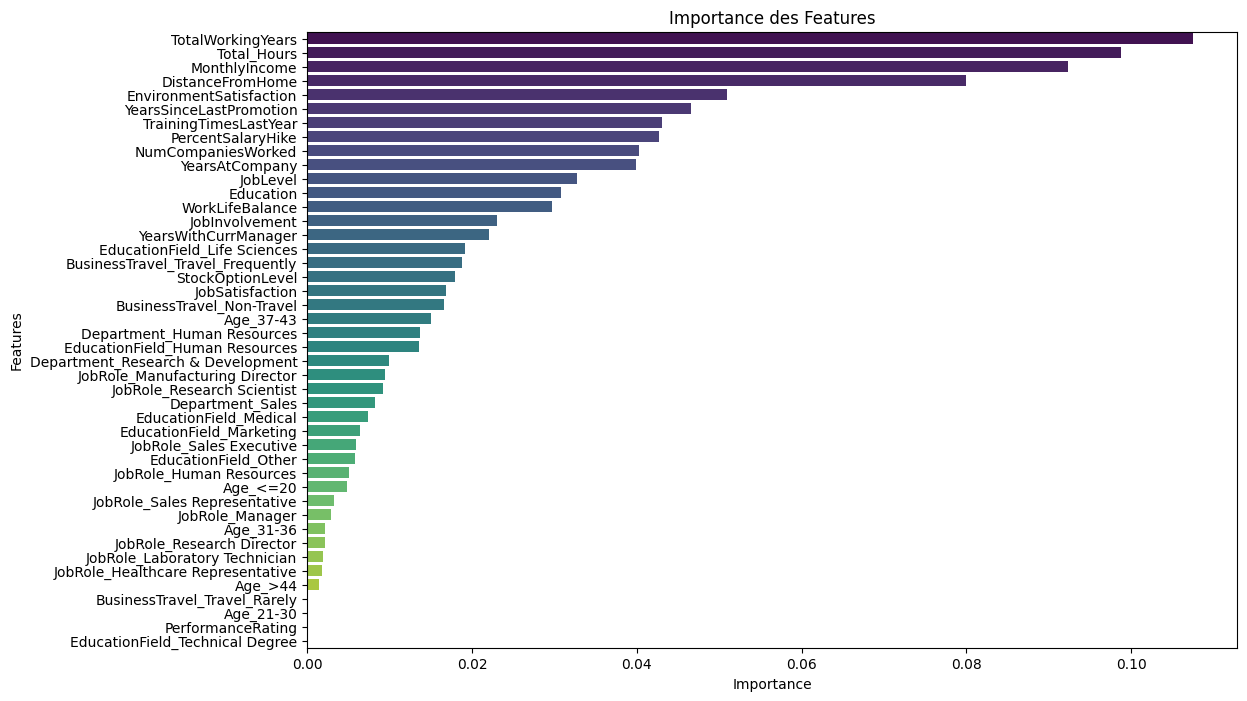

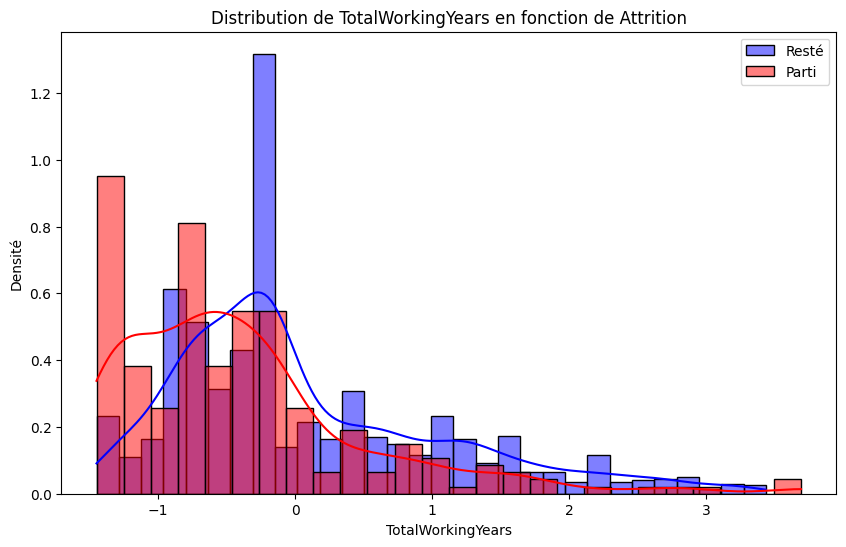

--------------------------------


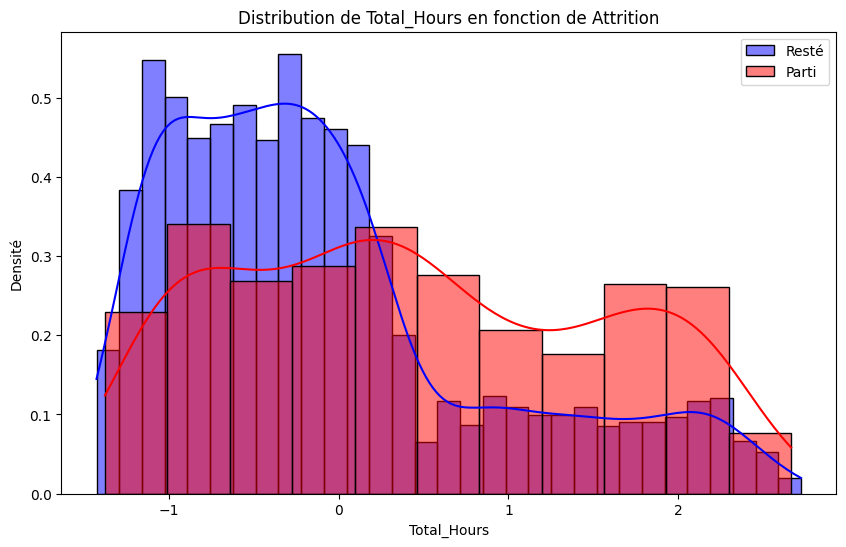

--------------------------------


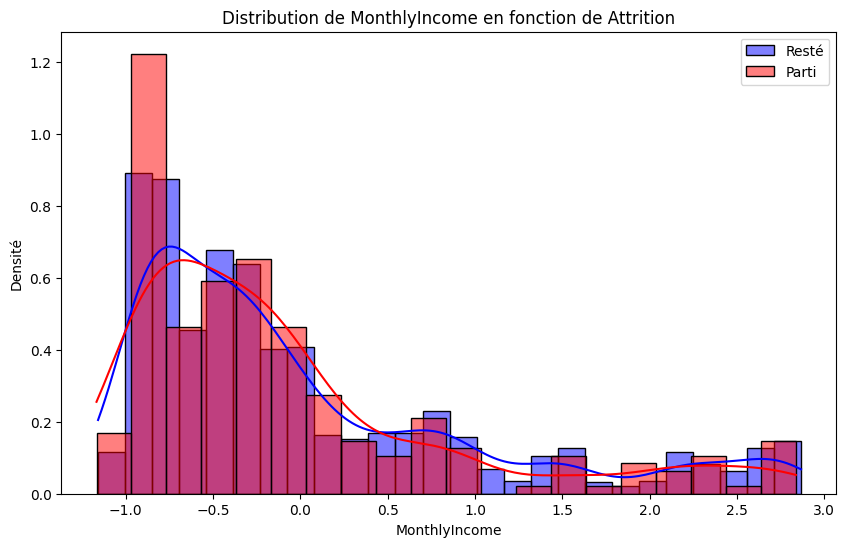

--------------------------------


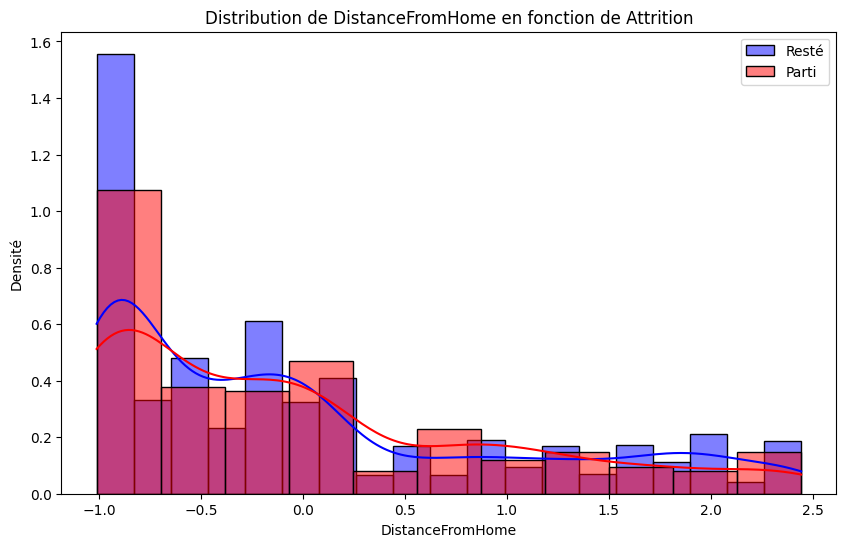

--------------------------------


In [157]:
importances = decision_tree_model.feature_importances_
feature_importances = pd.Series(importances, index=final_columns[:-1])
sorted_feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_importances.index, palette="viridis")
plt.title('Importance des Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

feature_distribution_with_attrition(sorted_feature_importances.head(4).index)

Nous avons donc les variables les plus impactantes après l'entraînement de notre modèle sur la variable cible qu'est l'attrition.<br>

`TotalWorkingYears` est la variable la plus influente, ce qui signifie que l'expérience professionnelle totale a un impact majeur sur la prédiction de l'attrition.<br>

`MonthlyIncome`, `DistanceFromHome` et `EnvironmentSatisfaction` sont aussi des variables clés, ce qui indique que le salaire, la distance domicile-travail et la satisfaction au travail jouent un rôle crucial dans la rétention des employés.<br>

Les caractéristiques liées à la promotion et aux augmentations de salaire (`YearsSinceLastPromotion`, `PercentSalaryHike`) sont également importantes, ce qui montre qu'un manque d'évolution professionnelle pourrait contribuer au départ des employés.<br>

D'autres variables comme le nombre d’entreprises précédentes travaillées (`NumCompaniesWorked`) et la fréquence de voyages professionnels (`BusinessTravel`) ont une influence notable.<br>

‎ 

Pour ce qui est de la distribution de la variable `TotalWorkingYears` en fonction de l’Attrition :
- Les employés qui partent (courbe rouge) ont une distribution de `TotalWorkingYears` plus concentrée vers les valeurs faibles, ce qui suggère que les employés avec peu d'expérience sont plus susceptibles de quitter l'entreprise.
- Les employés qui restent (courbe bleue) ont une distribution plus étalée, avec un pic autour d’un certain nombre d’années de travail, ce qui peut indiquer une stabilisation après un certain seuil.
- Cela confirme l’importance de l’expérience accumulée dans la rétention des employés.

‎ 

Pour `TotalHours` :
- Ceux qui travaillent très peu ou énormément ont plus de chances de partir.
- Un déséquilibre dans la charge de travail pourrait être un facteur d’attrition.

Pour `MonthlyIncome` : 
- Un salaire faible est un facteur de départ, ce qui est cohérent avec l’idée que les employés recherchent de meilleures opportunités ailleurs.
- L’entreprise pourrait réduire l’attrition en revoyant sa politique salariale.

Pour `DistanceFromHome` :
- Plus la distance domicile-travail est grande, plus l’attrition est élevée.
- Une politique de télétravail ou d’aide à la mobilité pourrait améliorer la rétention.

‎ 

**Synthèse globale**
- Expérience professionnelle (`TotalWorkingYears`) et promotions : Les employés avec peu d’expérience ou peu de progression partent plus facilement.
- Charge de travail (`Total_Hours`) : Un déséquilibre (trop ou pas assez de travail) peut provoquer des départs.
- Salaire (`MonthlyIncome`) : Un faible salaire est une cause majeure d’attrition.
- Distance domicile-travail (`DistanceFromHome`) : Plus la distance est grande, plus le risque de départ est élevé.

‎ 

──────────────────────────────────────────────────

#### 11.2. Recommandations

- Améliorer la rétention des jeunes employés avec des perspectives d’évolution.
- Optimiser la charge de travail pour éviter le surmenage ou l’ennui.
- Revoir la politique salariale pour les employés aux salaires les plus bas.
- Encourager le télétravail ou proposer des compensations pour ceux vivant loin.

---